# Predictive Maintenance of Industrial Machinery
*Improving Operational Efficiency Through Predictive Analytics*

## Introduction

Predictive maintenance focuses on anticipating equipment failures before they happen. This approach uses data and advanced technology to detect potential problems at an early stage, rather than waiting for a breakdown to occur. Companies can detect problems before they even happen by analyzing and evaluating sensor data using machine learning. 

Predictive maintenance is important for companies because it helps them avoid unplanned downtime, which can be very expensive. It can also reduce repair costs and extend the service life of industrial machines. Switching from a reactive to a proactive maintenance plan, companies can increase their productivity, keep their operations smooth and improve their profit.

## Goal

The goal of this project is to develop a predictive machine learning model capable of predicting failures in an industrial milling machine. The model will identify patterns and indicators of potential failures by analyzing historical data from the milling machine. This predictive capability seeks to improve operational efficiency, reduce repair costs and extend equipment life to ultimately ensure smoother production processes and higher overall productivity.

## Dataset Overview

The dataset used in this project is a synthetic dataset modeled after a milling machine, comprising 10,000 data points organized in rows with 14 distinct features in columns.

**Features**

- `UID`: unique identifier ranging from 1 to 10,000.

- `Product ID`: a combination of a letter (L, M, H) indicating quality (low, medium, high) with respective proportions of 50%, 30%, and 20%, followed by a variant-specific serial number.

- `Type`: product quality represented as a letter (L for low, M for medium, H for high).

- `Air temperature [K]`: generated using a random walk process, normalized to a standard deviation of 2 K around a mean of 300 K.

- `Process temperature [K]`: derived from a random walk process, normalized to a standard deviation of 1 K, and adjusted to the air temperature plus an additional 10 K.

- `Rotational speed [rpm]`: calculated based on a power output of 2860 W, with added normally distributed noise.

- `Torque [Nm]`: normally distributed around 40 Nm with a standard deviation of 10 Nm, ensuring all values are non-negative.

- `Tool wear [min]`: varies by quality variant, with additional wear times of 5, 3, and 2 minutes for high, medium, and low variants, respectively.

- `Machine failure`: a binary label indicating whether a machine failure occurred at this data point. It is set to 1 if at least one of the following independent failure modes is triggered:

    - `Tool Wear Failure (TWF)`: triggered when tool wear reaches a randomly selected time between 200 and 240 minutes.

    - `Heat Dissipation Failure (HDF)`: occurs if the temperature difference between air and process is below 8.6 K and rotational speed is below 1380 rpm.

    - `Power Failure (PWF)`: triggered when the power, calculated as the product of torque and rotational speed (in rad/s), falls below 3500 W or exceeds 9000 W.

    - `Overstrain Failure (OSF)`: occurs if the product of tool wear and torque exceeds thresholds (11,000 minNm for L, 12,000 for M, 13,000 for H).

    - `Random Failures (RNF)`: each process has a 0.1% probability of failing, independent of other parameters.

**Publication Reference**

This dataset is part of the following publication:

_S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), pp. 69-74._

## Import libraries

All the libraries needed for this project are imported.

In [1]:
# Project setup
%run ../notebooks/setup_path.py
from config import *

# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import label_binarize

# Resampling
from imblearn.over_sampling import SMOTE

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Saving the model
import pickle

# Model interpretation
import shap

## Data loading

The CSV file `predictive-maintenance-dataset-ai4i2020` is loaded as a pandas DataFrame.

In [2]:
# Load the dataset
df = pd.read_csv(RAW_DIR / "predictive-maintenance-dataset-ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Data cleaning

The dataset is cleaned and pre-processed to prepare it for further analysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### Remove unncessary columns

The columns UDI and Product ID are used as indexes and do not carry predictive value, so they are removed from the dataset.

In [4]:
df = df.drop(["UDI", "Product ID"], axis = 1)

### Rename columns

Some column names are updated to make the dataset easier to read and understand.

In [5]:
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [6]:
df = df.rename(columns = {"Type" : "Product_quality",
                          "Air temperature [K]" : "Air_temperature_K",
                          "Process temperature [K]" : "Process_temperature_K",
                          "Rotational speed [rpm]" : "Rotational_speed_rpm",
                          "Torque [Nm]" : "Torque_Nm",
                          "Tool wear [min]" : "Tool_wear_min",
                          "Machine failure" : "Machine_failure"})

In [7]:
df.head()

,Product_quality,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Data types

Verify that all columns have the correct data types.

In [8]:
df.dtypes

Product_quality           object
Air_temperature_K        float64
Process_temperature_K    float64
Rotational_speed_rpm       int64
Torque_Nm                float64
Tool_wear_min              int64
Machine_failure            int64
TWF                        int64
HDF                        int64
PWF                        int64
OSF                        int64
RNF                        int64
dtype: object

Set numerical features **Rotational_speed_rpm** and **Tool_wear_min** to float type.

In [9]:
df["Rotational_speed_rpm"] = df["Rotational_speed_rpm"].astype("float64")
df["Tool_wear_min"] = df["Tool_wear_min"].astype("float64")

### Null values

Identify and remove any missing values from the dataset if necessary.

In [10]:
# Check the total of null values in each column
df.isna().sum()

Product_quality          0
Air_temperature_K        0
Process_temperature_K    0
Rotational_speed_rpm     0
Torque_Nm                0
Tool_wear_min            0
Machine_failure          0
TWF                      0
HDF                      0
PWF                      0
OSF                      0
RNF                      0
dtype: int64

The dataset has no missing values.

### Duplicated values

Check the dataset for duplicate records and handle them as needed.

In [11]:
df.duplicated().sum()

0

The dataset has no duplicate values.

### Outliers

Review the dataset’s statistical summary to spot any potential outliers. This overview helps identify unusual values that might need further attention.

In [12]:
df.describe()

,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Machine_failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


The statistics for torque and rotational speed indicate the presence of outliers. However, as noted in the dataset overview, extreme values in these features are related to machinery failures. For this reason, these outliers will be kept to help improve prediction accuracy. To better understand these extreme values, the distributions of both features will be plotted for visualization.

<Figure size 640x480 with 0 Axes>

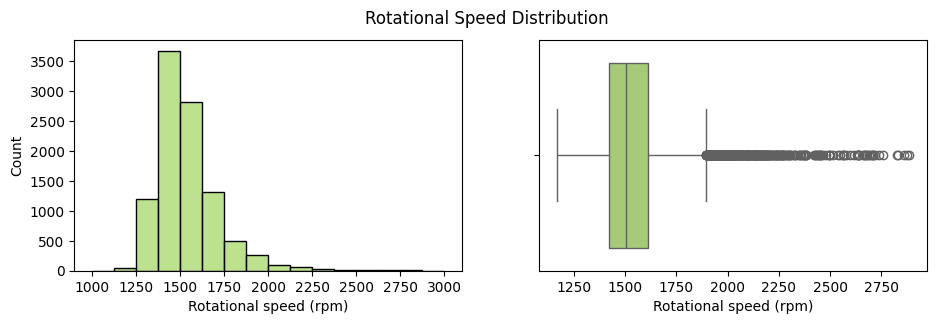

In [13]:
# Plot the rotational speed distribution using a histogram and boxplot
rotational_speed_distribution = plt.figure()
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.histplot(df["Rotational_speed_rpm"], ax = ax[0], bins = 16, binrange = (1000, 3000), color = "#a6d96a")
sns.boxplot(x = df["Rotational_speed_rpm"], ax = ax[1], color = "#a6d96a")
ax[0].set_xlabel("Rotational speed (rpm)")
ax[1].set_xlabel("Rotational speed (rpm)")
plt.suptitle("Rotational Speed Distribution", size = 12);

<Figure size 640x480 with 0 Axes>

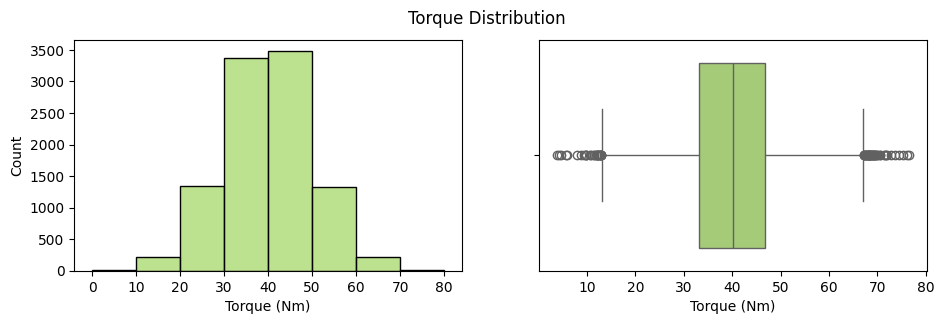

In [14]:
# Plot torque distribution using a histogram and boxplot
torque_distribution = plt.figure()
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.histplot(df["Torque_Nm"], ax = ax[0], bins = 8, binrange = (0, 80), color = "#a6d96a")
sns.boxplot(x = df["Torque_Nm"], ax = ax[1], color = "#a6d96a")
ax[0].set_xlabel("Torque (Nm)")
ax[1].set_xlabel("Torque (Nm)")
plt.suptitle("Torque Distribution", size = 12);

### The clean dataset

This dataset represents the final version after all cleaning and preprocessing steps have been completed. It is now ready for further analysis and modeling.

In [15]:
predictive_maintenance = df.copy()
predictive_maintenance.head()

,Product_quality,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551.0,42.8,0.0,0,0,0,0,0,0
1,L,298.2,308.7,1408.0,46.3,3.0,0,0,0,0,0,0
2,L,298.1,308.5,1498.0,49.4,5.0,0,0,0,0,0,0
3,L,298.2,308.6,1433.0,39.5,7.0,0,0,0,0,0,0
4,L,298.2,308.7,1408.0,40.0,9.0,0,0,0,0,0,0


In [16]:
# Save the cleaned dataset
predictive_maintenance.to_csv(PROCESSED_DIR / "Predictive-maintenance-cleaned-dataset.csv")

## Data exploration

This section covers a detailed exploratory analysis of the data.

### Univariate exploration

- **Features distribution**

The first step is to examine each feature in the dataset to obtain a general overview of their distributions. The histograms reveal that the data is imbalanced, particularly in the following features: **Product_quality, Machine _failure, TWF, HDF, PWF, OSF, and RNF**.

Imbalanced data occurs when one category in a dataset significantly outnumbers another, such as 90% in category A and 10% in category B. This can lead to biased models that favor the majority category, making it difficult to predict outcomes for the minority category. Techniques like resampling, adjusting category weights, or using specialized algorithms can help address this issue.

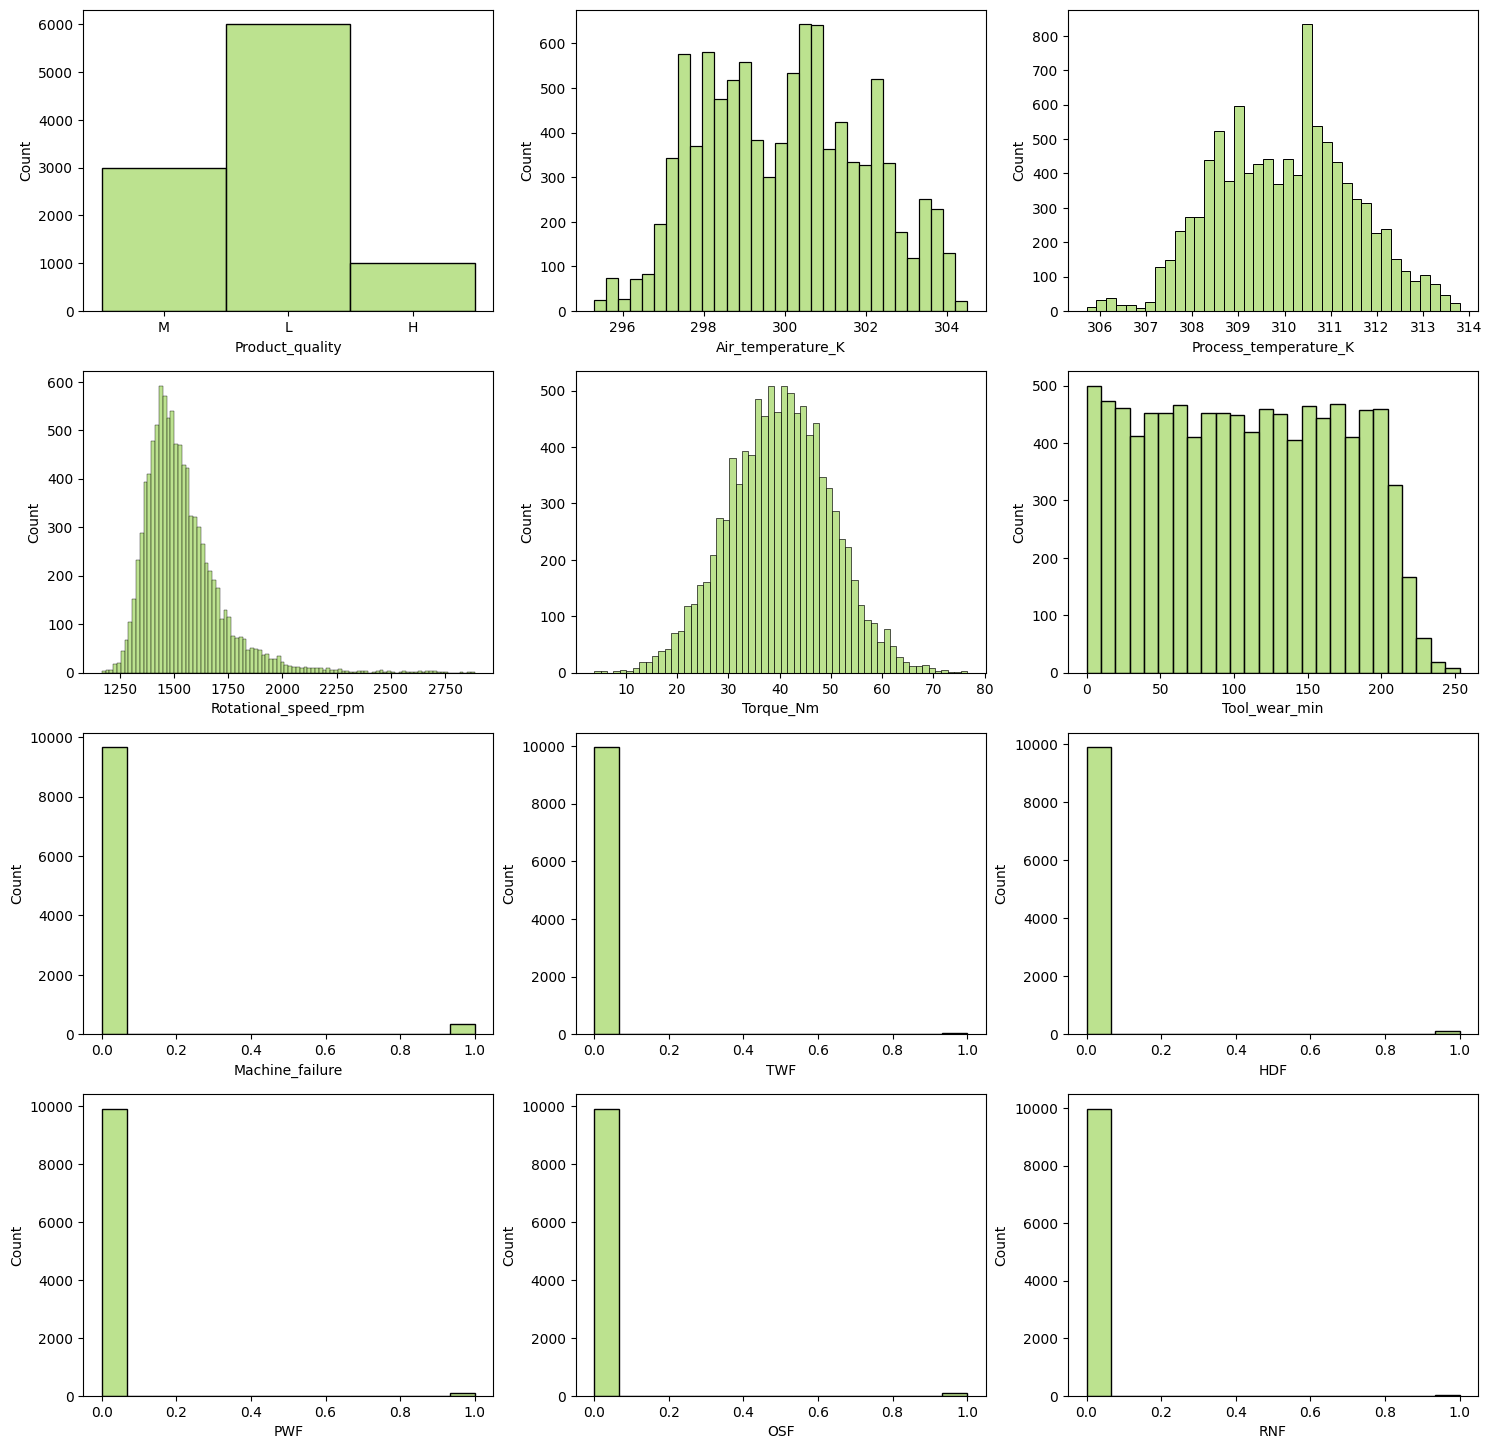

In [17]:
# Plot distribution of all feature on the datasest
fig, ax = plt.subplots(4, 3, figsize = (18, 18))
for i, col in enumerate(predictive_maintenance.columns):
    sns.histplot(predictive_maintenance[col], ax = ax[i//3][i%3], color = "#a6d96a")

- **Product quality**

Let’s take a look at the distribution of the product quality feature.

There are three different quality categories: low, medium, and high. The distribution is notably unbalanced, with the "low" quality category having significantly more observations compared to the other two categories.

In [18]:
product_quality_dist = predictive_maintenance["Product_quality"].value_counts()
product_quality_dist

Product_quality
L    6000
M    2997
H    1003
Name: count, dtype: int64

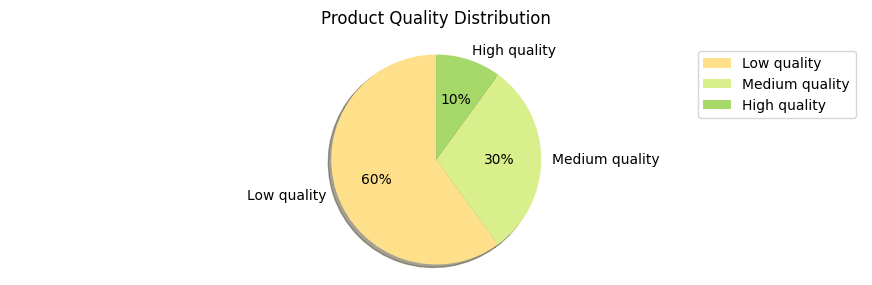

In [19]:
labels = ["Low quality", "Medium quality", "High quality"]
colors = ["#fee08b", "#d9ef8b", "#a6d96a"]

product_quality_dist_graph = plt.figure(figsize = (11, 3))
plt.pie(product_quality_dist, labels = labels, colors = colors, startangle = 90, autopct="%1.0f%%", shadow = True)
plt.axis("equal")
plt.legend()
plt.title("Product Quality Distribution", pad = 15)
plt.savefig(FIGURES_DIR / "eda" / "Product-quality-distribution-pie-plot.png")

- **Machine failure**

This column is the target variable for the project, representing machine failure. It’s binary, with values of 1 and 0. The histogram above shows that the dataset is imbalanced, but a deeper analysis will follow to explore this in more detail.

In [20]:
machine_failure_dist = predictive_maintenance["Machine_failure"].value_counts()
machine_failure_dist

Machine_failure
0    9661
1     339
Name: count, dtype: int64

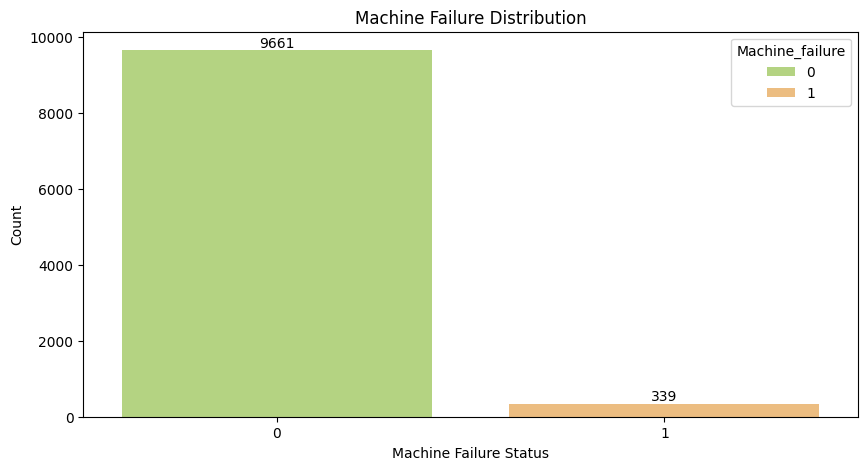

In [21]:
machine_failure_dist_graph = plt.figure(figsize = (10, 5))
ax = sns.countplot(predictive_maintenance, x = "Machine_failure", hue = "Machine_failure", palette = "RdYlGn_r")
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel("Machine Failure Status")
plt.ylabel("Count")
plt.title("Machine Failure Distribution", size = 12)
plt.savefig(FIGURES_DIR / "eda" / "Machine-failure-distribution-bar-plot.png")

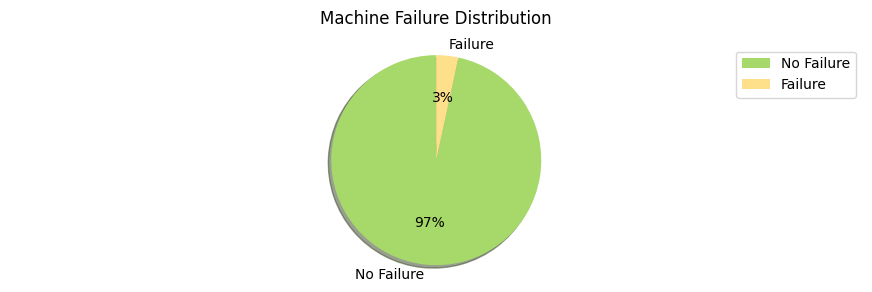

In [22]:
labels = ["No Failure", "Failure"]
colors = [ "#a6d96a", "#fee08b"]

machine_failure_percentage_graph = plt.figure(figsize = (11, 3))
plt.pie(machine_failure_dist, labels = labels, colors = colors, startangle = 90, autopct="%1.0f%%", shadow = True)
plt.axis("equal")
plt.legend()
plt.title("Machine Failure Distribution", pad = 15)
plt.savefig(FIGURES_DIR / "eda" / "Machine-failure-distribution-pie-plot.png")

- **Machine failure percentage by product quality**

The low-quality product has a higher machine failure rate of 4%, while the medium-quality product has a failure rate of 3%. In contrast, the high-quality product demonstrates the lowest failure rate at 2%.

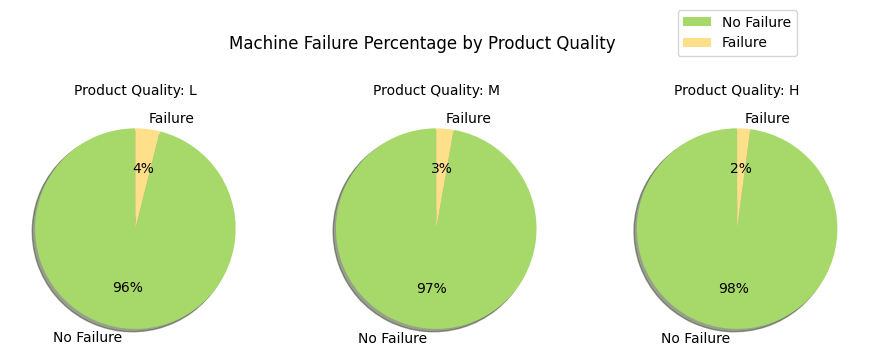

In [23]:
labels = ["No Failure", "Failure"]
colors = ["#a6d96a", "#fee08b"]

fig, ax = plt.subplots(1, 3, figsize=(11, 4))

ax = ax.flatten()

for j, quality in enumerate(["L", "M", "H"]):
    df_product_type = predictive_maintenance[predictive_maintenance["Product_quality"] == quality]
    ax[j].pie(df_product_type["Machine_failure"].value_counts(), labels = labels, colors = colors, startangle = 90, autopct = "%1.0f%%", shadow = True)
    ax[j].set_title(f"Product Quality: {quality}", size = 10)

plt.suptitle("Machine Failure Percentage by Product Quality", size = 12)
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.4))
plt.savefig(FIGURES_DIR / "eda" / "Machine-failure-percentage-by-product-quality.png")

- **Type of failure**

There are five different types of failures: TWF, HDF, PWF, OSF, RNF.

The machine failure distribution bar plot illustrates that the most frequent machine failure is HDF, followed by OSF. In contrast, RNF has the fewest observations, which is expected, as it represents a random failure occurring at a rate of just 0.1%, regardless of the parameters.

In [24]:
# Create a dataframe containing only the different types of machine failure
machine_failure_types = predictive_maintenance.loc[:, ["TWF", "HDF", "PWF", "OSF", "RNF"]]

In [25]:
# Sum the number of times a failure was registered in the dataset
sum_failures = machine_failure_types.sum().sort_values(ascending=True)
sum_failures

RNF     19
TWF     46
PWF     95
OSF     98
HDF    115
dtype: int64

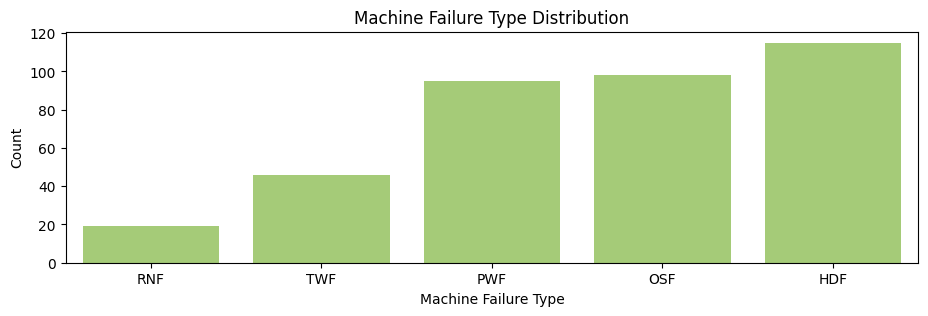

In [26]:
failure_types_distribution_graph = plt.figure(figsize = (11, 3))
sns.barplot(sum_failures, color = "#a6d96a")
plt.xlabel("Machine Failure Type")
plt.ylabel("Count")
plt.title("Machine Failure Type Distribution", size = 12)
plt.savefig(FIGURES_DIR / "eda" / "Machine-failure-type-distribution.png")

An additional step will be taken to investigate whether multiple failures occur simultaneously.

In [27]:
# Sum failure values per row
sum_rows = machine_failure_types.sum(axis = 1)

Text(0.5, 1.0, 'Distribution of Simultaneous Failures')

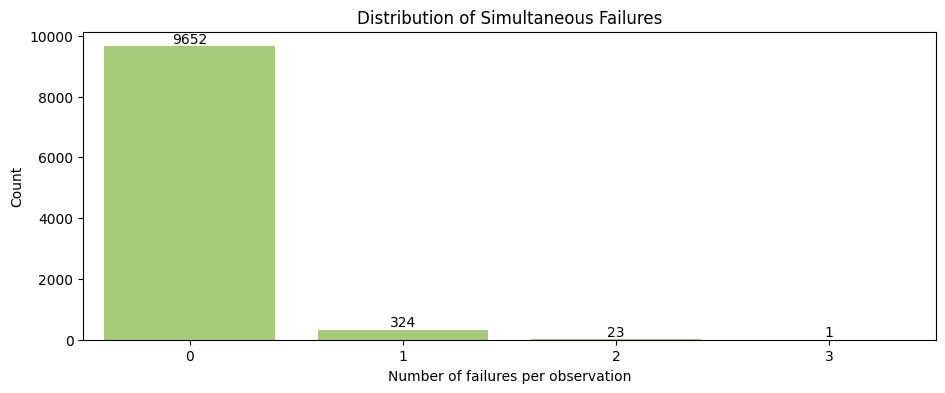

In [28]:
# Plot count of failure types happening simultaneously
count_simultaneous_failures = plt.figure(figsize = (11, 4))
ax = sns.countplot(x = sum_rows, color = "#a6d96a")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), ha = "center", va = "bottom")
plt.xlabel("Number of failures per observation")
plt.ylabel("Count")
plt.title("Distribution of Simultaneous Failures", size = 12)

Some observations experience multiple failures simultaneously, although the frequency is quite low. Specifically, there are 23 instances of two machine failures occurring at the same time, and one instance of three machine failures happening simultaneously

- **Type of machine failure per product quality**

In [29]:
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]

failure_per_quality = pd.DataFrame()

for type in failure_types: 
    sum = predictive_maintenance.groupby("Product_quality")[type].sum()
    failure_per_quality = pd.concat([failure_per_quality, sum], axis = 1)

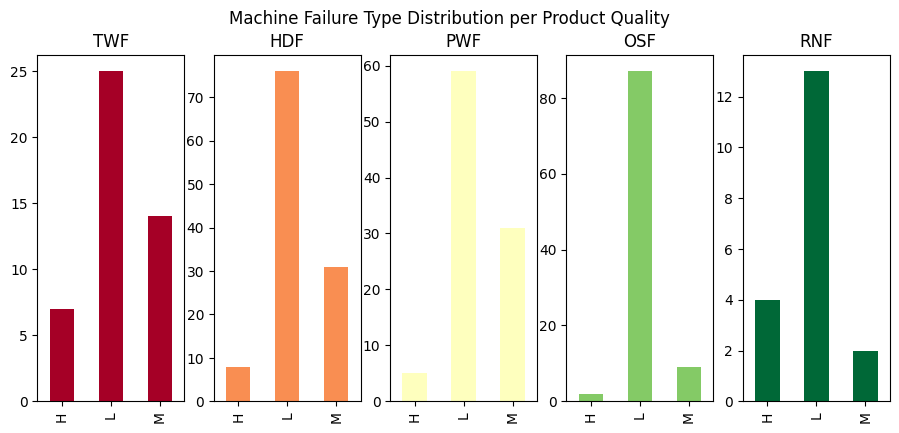

In [30]:
failure_per_quality.plot(figsize = (11, 4.5), subplots=True, layout= (1,5), legend = False,
                         kind = "bar", colormap = "RdYlGn", title = "Machine Failure Type Distribution per Product Quality")
plt.savefig(FIGURES_DIR / "eda" / "Machine-failure-type-distribution-per-product-quality.png")

It has already been established that low-quality products have a higher percentage of machine failures. Analyzing each failure type individually reveals a consistent pattern: products with lower quality experience more failures, while higher quality products have fewer failures. However, in the case of RNF failures, it was observed that the failure rate is higher for high-quality products compared to medium-quality ones.

- **Drop the RNF failures**

RNF represents a random failure occurring at a rate of just 0.1%, regardless of the parameters, it lacks predictive value therefore it is drop from the dataset.

In [31]:
predictive_maintenance = predictive_maintenance.drop("RNF", axis = 1)

**In Summary:**

- There are three types of product quality: low, medium, and high.
- Machine failures account for only 3% of the observations in the dataset.
- The incidence of machine failures is notably higher among lower-quality products.
- There are five types of machine failures: TWF, HDF, PWF, OSF, and RNF.
- The most frequent failures are HDF, OSF, and PWF.
- For all types of machine failures, lower-quality products exhibit a higher failure count, with the exception of RNF failures.

### Bivariate exploration

- **Correlation matrix**

A correlation matrix is used to find the correlation between features.

In [32]:
correlations = predictive_maintenance.corr(numeric_only = True)
correlations

,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Machine_failure,TWF,HDF,PWF,OSF
Air_temperature_K,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.009955,0.137831,0.003470,0.001988
Process_temperature_K,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.007315,0.056933,-0.003355,0.004554
Rotational_speed_rpm,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,0.010389,-0.121241,0.123018,-0.104575
Torque_Nm,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,-0.014662,0.142610,0.083781,0.183465
Tool_wear_min,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.115792,-0.001287,-0.009334,0.155894
Machine_failure,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.362904,0.575800,0.522812,0.531083
TWF,0.009955,0.007315,0.010389,-0.014662,0.115792,0.362904,1.000000,-0.007332,0.008577,0.038243
HDF,0.137831,0.056933,-0.121241,0.142610,-0.001287,0.575800,-0.007332,1.000000,0.018443,0.046396
PWF,0.003470,-0.003355,0.123018,0.083781,-0.009334,0.522812,0.008577,0.018443,1.000000,0.115836
OSF,0.001988,0.004554,-0.104575,0.183465,0.155894,0.531083,0.038243,0.046396,0.115836,1.000000


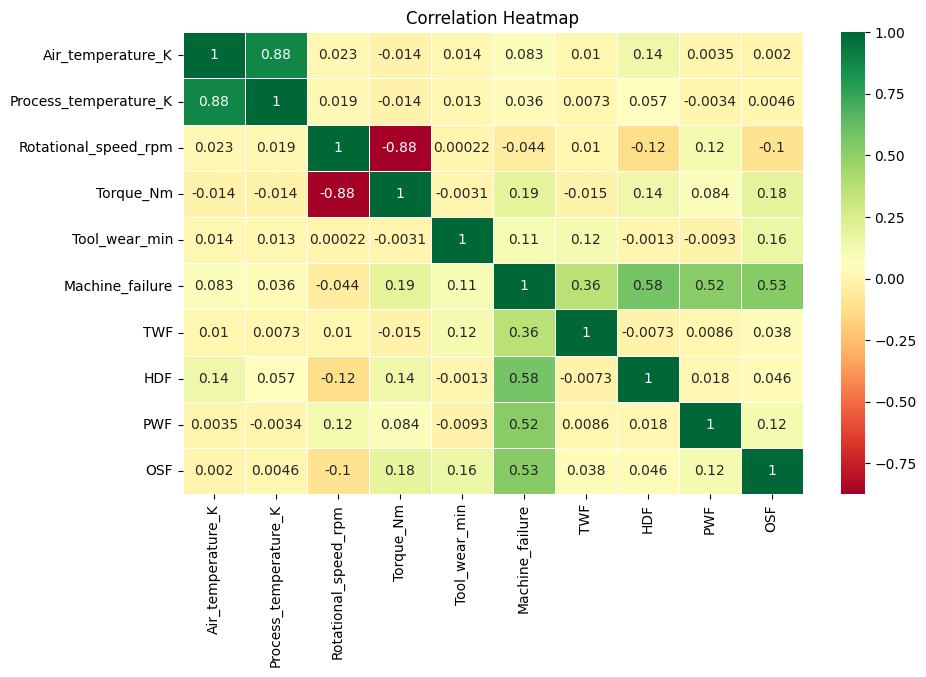

In [33]:
correlation_heatmap_graph = plt.figure(figsize = (10, 6))
sns.heatmap(correlations, linewidths = 0.5, annot = True, cmap = "RdYlGn")
plt.title("Correlation Heatmap", size = 12)
plt.savefig(FIGURES_DIR / "eda" / "Correlation-heatmap.png")

The correlation study reveals two important relationships: 

- There is a high positive correlation between air temperature and process temperature, which means that when air temperature rises, so does process temperature.
- There is a high negative correlation between torque and rotational speed, meaning that as torque rises, rotational speed falls.

The heatmap also confirms that the strongest relationships with machine failure are found in HDF, OSF, and PWF, as previously established.

- **Pairplot Visualization**

Next, pairplot visualization are used to spot trend, outliers and relationships between multiple variables in a dataset.

In [34]:
# Drop the different machine failure types from the dataset
columns_to_drop = ["TWF", "HDF", "PWF", "OSF"]
df_dropped = predictive_maintenance.drop(columns_to_drop, axis = 1) 

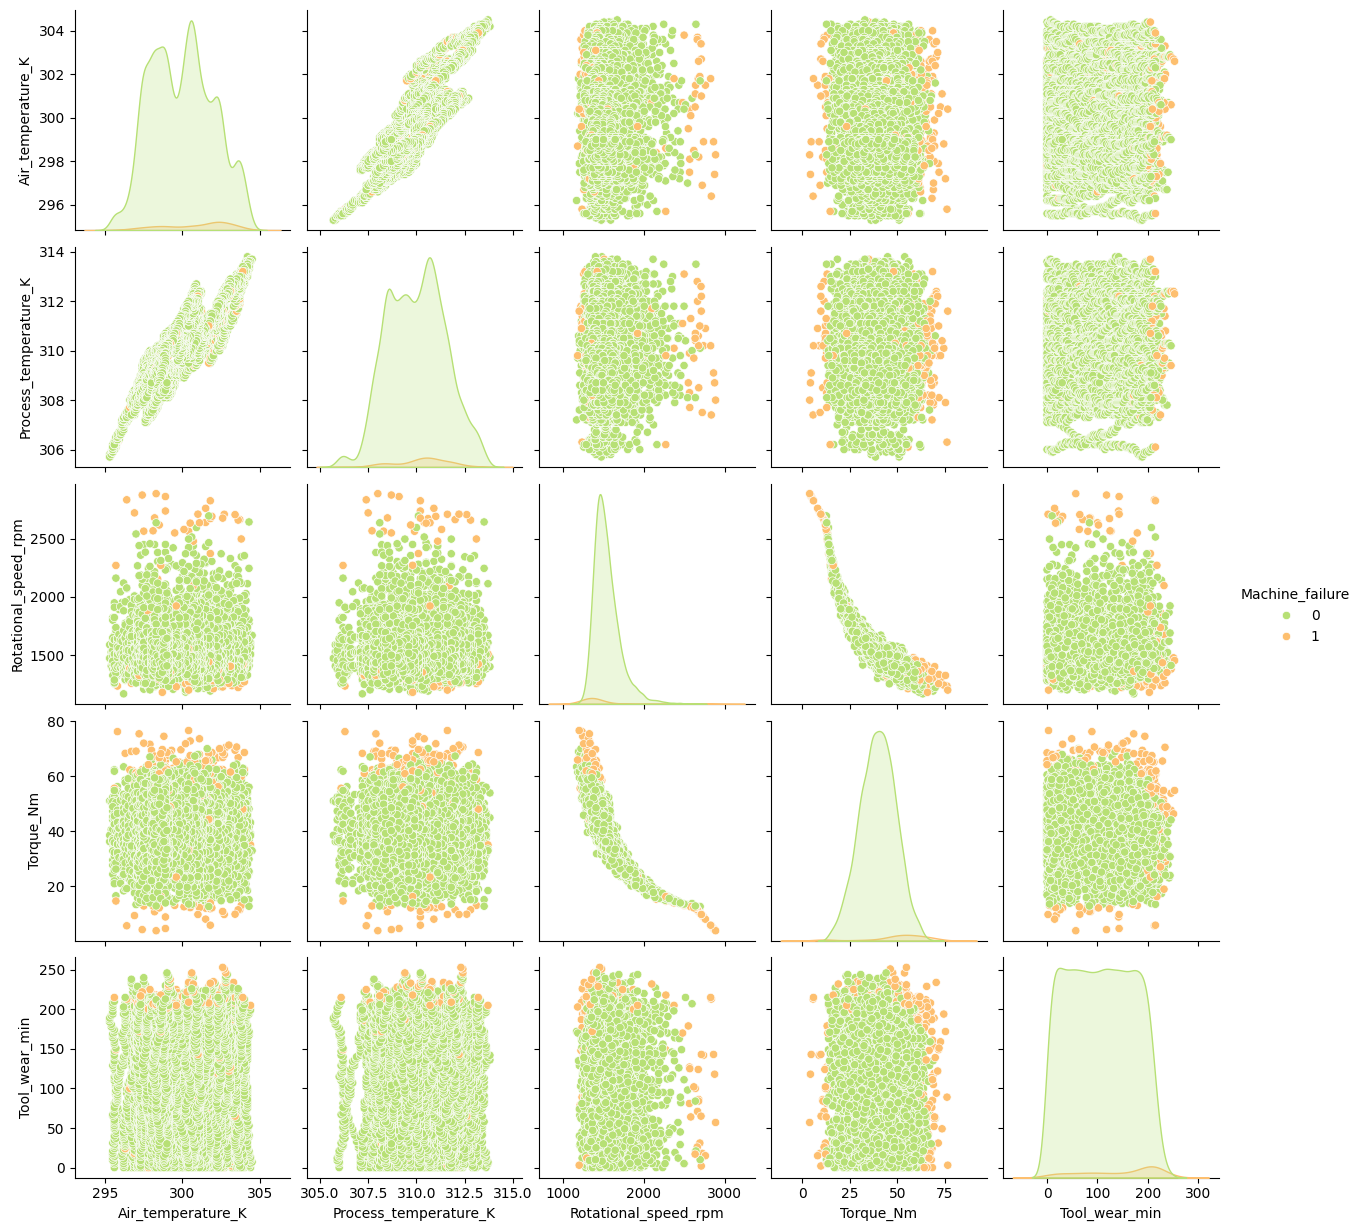

In [35]:
# Create a pairplot to visualize pairwise relationships between features in df_dropped
sns.pairplot(df_dropped, hue = "Machine_failure", palette = "RdYlGn_r")

The pairplot analysis reveals that machine failures happen at extreme values of torque and rotational speed, being either very low or very high. This is clear from the graph, where the orange dots (representing failures) are spread across these zones. It suggests that there is a safe operating range for the machines, and when the values fall outside this range, the risk of failure increases. Therefore, the next step consists of plotting torque versus rotational speed for each type of failure. This will help identify the specific ranges in which each type of failure occurs.

Text(0, 0.5, 'Torque (Nm)')

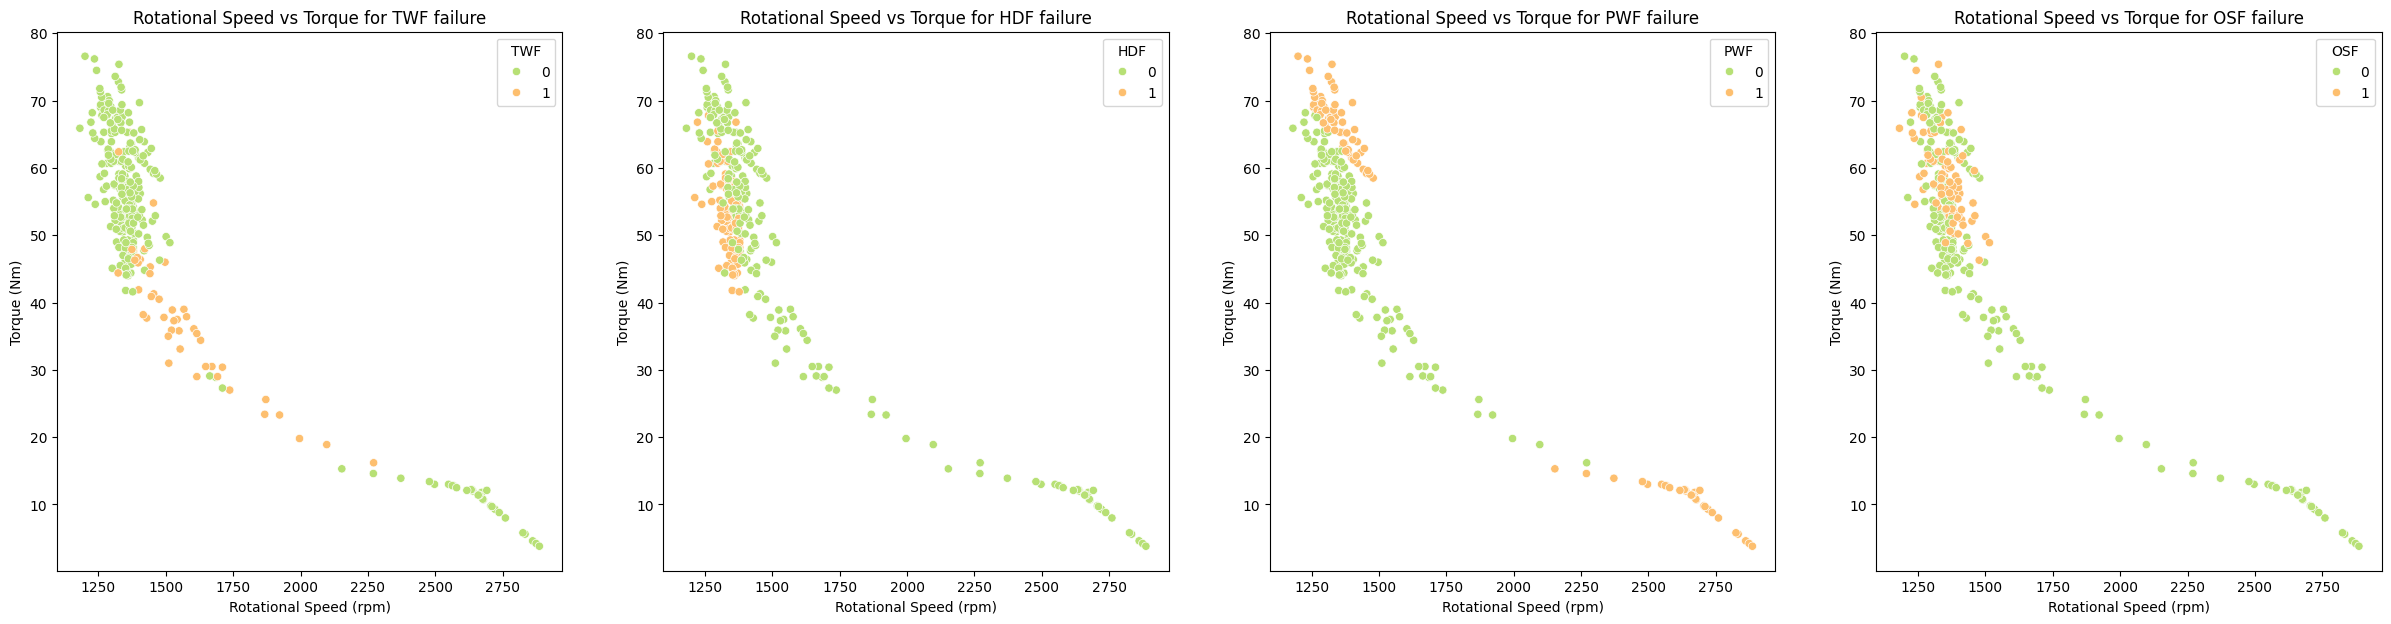

In [36]:
# Plot torque vs rotational speed for each failure type
fig, ax = plt.subplots(1, 4, figsize = (30, 7))

ax = ax.flatten()

sns.scatterplot(data = predictive_maintenance[predictive_maintenance["Machine_failure"] == 1], x = "Rotational_speed_rpm", y = "Torque_Nm", 
                hue = "TWF", ax = ax[0], palette = "RdYlGn_r")
ax[0].set_title("Rotational Speed vs Torque for TWF failure")
ax[0].set_xlabel("Rotational Speed (rpm)")
ax[0].set_ylabel("Torque (Nm)")

sns.scatterplot(data = predictive_maintenance[predictive_maintenance["Machine_failure"] == 1], x = "Rotational_speed_rpm", y = "Torque_Nm", 
                hue = "HDF", ax = ax[1], palette = "RdYlGn_r")
ax[1].set_title("Rotational Speed vs Torque for HDF failure")
ax[1].set_xlabel("Rotational Speed (rpm)")
ax[1].set_ylabel("Torque (Nm)")

sns.scatterplot(data = predictive_maintenance[predictive_maintenance["Machine_failure"] == 1], x = "Rotational_speed_rpm", y = "Torque_Nm", 
                hue = "PWF", ax = ax[2], palette = "RdYlGn_r")
ax[2].set_title("Rotational Speed vs Torque for PWF failure")
ax[2].set_xlabel("Rotational Speed (rpm)")
ax[2].set_ylabel("Torque (Nm)")

sns.scatterplot(data = predictive_maintenance[predictive_maintenance["Machine_failure"] == 1], x = "Rotational_speed_rpm", y = "Torque_Nm", 
                hue = "OSF", ax = ax[3], palette = "RdYlGn_r")
ax[3].set_title("Rotational Speed vs Torque for OSF failure")
ax[3].set_xlabel("Rotational Speed (rpm)")
ax[3].set_ylabel("Torque (Nm)")

**Torque vs. Rotational Speed: Key Insights**

* **Tool Wear Failures (TWF):** occur at lower torque and rotational speed values.
* **Heat Dissipation Failures (HDF):** happen with high torque and low rotational speed.
* **Power Failures (PWF):** can occur in either high torque with low rotational speed or low torque with high rotational speed.
* **Overstrain Failures (OSF):** take place under high torque and low rotational speed, similar to heat dissipation failures.

## Pre-processing

The goal of this project is to predict milling machine failure. There are two ways to approach this. The first is a binary classification task, where the model predicts whether the machine will fail or not, using the “Machine_failure” feature as the target. The second approach is to build a multiclass classification model that not only predicts failure but also identifies the specific type of failure. The latter approach offers more insight, so this project will focus on developing a multiclass classifier.

### Update the column "Machine_failure" to include all the failure types

Since the problem will be treated as a multiclass classification, the "Machine_failure" column should be updated to include all types of failures.

In [37]:
predictive_maintenance["Machine_failure"] = 0

# Update the machine failure column based on the types of failure
predictive_maintenance.loc[predictive_maintenance["TWF"] == 1, "Machine_failure"] = 1
predictive_maintenance.loc[predictive_maintenance["HDF"] == 1, "Machine_failure"] = 2
predictive_maintenance.loc[predictive_maintenance["PWF"] == 1, "Machine_failure"] = 3
predictive_maintenance.loc[predictive_maintenance["OSF"] == 1, "Machine_failure"] = 4

# Drop individual failure type columns
predictive_maintenance.drop(columns_to_drop, axis = 1, inplace = True)

In [38]:
predictive_maintenance["Machine_failure"].value_counts()

Machine_failure
0    9670
2     106
4      98
3      83
1      43
Name: count, dtype: int64

### Encoding categorical data

Most machine learning models need numerical inputs, so categorical variables must be converted to numbers to help the model understand the data. For features that have a natural order, such as “low,” “medium” and “high,” ordinal coding is a good option. This method assigns an integer to each category based on its order. The use of ordinal coding in decision tree or random forest models allows the algorithm to recognize these relationships, leading to better splits and better performance.

In [39]:
# Create an instance of OrdinalEncoder
encoder = OrdinalEncoder(categories=[["L", "M", "H"]])

# Fit and transform the data
predictive_maintenance["Priority_quality_encoded"] = encoder.fit_transform(predictive_maintenance[["Product_quality"]])
predictive_maintenance.drop(["Product_quality"], axis = 1, inplace = True)
predictive_maintenance

,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Machine_failure,Priority_quality_encoded
0,298.1,308.6,1551.0,42.8,0.0,0,1.0
1,298.2,308.7,1408.0,46.3,3.0,0,0.0
2,298.1,308.5,1498.0,49.4,5.0,0,0.0
3,298.2,308.6,1433.0,39.5,7.0,0,0.0
4,298.2,308.7,1408.0,40.0,9.0,0,0.0
...,...,...,...,...,...,...,...
9995,298.8,308.4,1604.0,29.5,14.0,0,1.0
9996,298.9,308.4,1632.0,31.8,17.0,0,2.0
9997,299.0,308.6,1645.0,33.4,22.0,0,1.0
9998,299.0,308.7,1408.0,48.5,25.0,0,2.0


### Feature scaling

Decision Tree or Random Forest models do not need standardization of features. They split data based on feature values, so the scale of the features doesn't affect the model's performance.

## Data splitting

The dataset is divided into two main parts: the training set (80%) and the testing set (20%). This is done to avoid overfitting by training on one set and testing in another, and to perform the evaluation of the model. 

- **Training set**: this is the portion of the dataset used to train the model. During training, the model learns patterns, relationships, and features from the data.

- **Testing set**: this set is used to evaluate the model's performance after training. It helps assess how well the model generalizes to unseen data.

In [40]:
# Independent features
X = predictive_maintenance.drop("Machine_failure", axis = 1)

# Dependent or target feature
y = predictive_maintenance["Machine_failure"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = SEED)
print("Training set - X_train shape:", X_train.shape)
print("Testing set - X_test shape:", X_test.shape)
print("Training set - y_train shape:", y_train.shape)
print("Testing set - y_test shape:", y_test.shape)

Training set - X_train shape: (8000, 6)
Testing set - X_test shape: (2000, 6)
Training set - y_train shape: (8000,)
Testing set - y_test shape: (2000,)


## Data Sampling

The dataset has notable class imbalances, which will be addressed throughout the project. The bar chart below shows the distribution of different machine failure types in the training set.

In [41]:
y.value_counts()

Machine_failure
0    9670
2     106
4      98
3      83
1      43
Name: count, dtype: int64

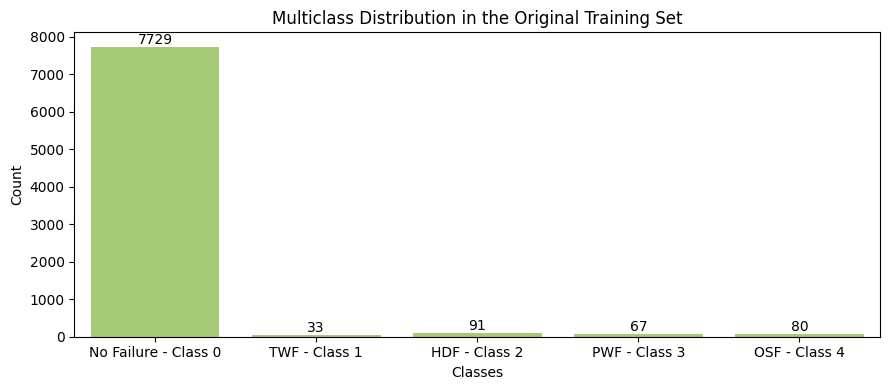

In [42]:
count_class = y_train.value_counts().sort_index()
plt.figure(figsize = (9, 4))
ax = sns.barplot(count_class, color = "#a6d96a")
plt.xticks(ticks = count_class.index, labels = ["No Failure - Class 0", "TWF - Class 1", "HDF - Class 2", "PWF - Class 3", "OSF - Class 4"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("Count")
plt.xlabel("Classes")
plt.title("Multiclass Distribution in the Original Training Set")
plt.tight_layout()

### Addressing Imbalance

Class imbalance is a common challenge in machine learning because it can skew model training and affect how results are interpreted. For example, a model that always predicts no failure could still achieve 97% accuracy but wouldn’t detect any failures.

To address this, data augmentation is applied to create an 80/20 ratio between no-failure and failure observations, while ensuring the failure causes are evenly distributed.

Common data augmentation methods include:

1. **Under-sampling:** reducing instances from the majority class.
2. **Over-sampling:** duplicating instances from the minority class.
3. **SMOTE (Synthetic Minority Oversampling Technique):** generating new synthetic samples.

Under-sampling and over-sampling can lead to data loss or oversimplification, especially when the dataset is small. Since class 1 has far fewer observations than other classes, SMOTE is chosen for this project. SMOTE generates new samples by slightly adjusting existing minority class points toward their nearest neighbors. It selects a minority class sample, finds its *k* nearest neighbors, and creates new data points by scaling the distance between them. This method expands the minority class while preserving its characteristics.

After splitting the dataset into training and test sets, SMOTE is applied **only** to the training set. This keeps the test set as a true reflection of the original data and prevents information leakage, ensuring a fair evaluation of the model.

In [43]:
# Apply SMOTE to the training data to create an oversampled dataset
oversample = SMOTE(random_state = SEED)
X_oversampled, y_oversampled = oversample.fit_resample(X_train, y_train)

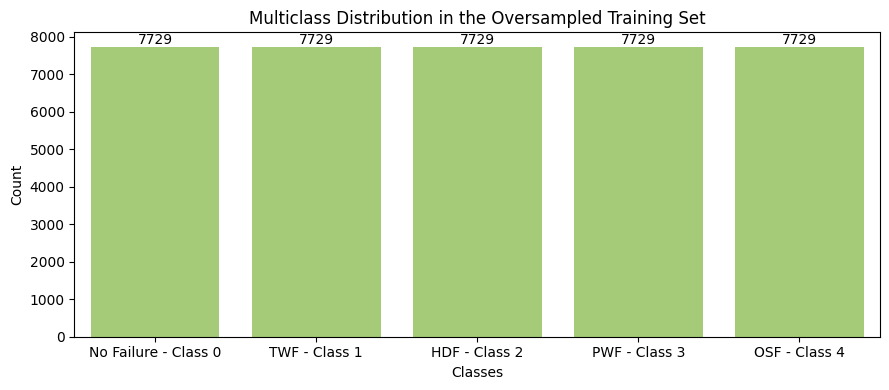

In [44]:
oversampled_count_class = y_oversampled.value_counts().sort_index()
plt.figure(figsize = (9, 4))
ax = sns.barplot(oversampled_count_class, color = "#a6d96a")
plt.xticks(ticks = oversampled_count_class.index, labels = ["No Failure - Class 0", "TWF - Class 1", "HDF - Class 2", "PWF - Class 3", "OSF - Class 4"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("Count")
plt.xlabel("Classes")
plt.title("Multiclass Distribution in the Oversampled Training Set")
plt.tight_layout()

As shown in the bar chart above, SMOTE has successfully balanced the training set by oversampling. Now, all classes have an equal number of observations.

## Model selection

This part of the project focuses on developing a predictive machine learning model to forecast failures in an industrial milling machine. The selected algorithms are **decision tree** and **random forest**, both well-suited for analyzing complex datasets and detecting patterns that indicate potential failures.

### Decision Tree Model

First, a decision tree model was trained and evaluated in two ways: using the original dataset and then the oversampled dataset created with SMOTE to address class imbalance. This comparison helps show how balancing the data affects the model’s prediction accuracy.

A decision tree is an easy-to-understand machine learning algorithm that makes predictions by splitting data based on specific features. Think of it like a flowchart where each question leads to a different path. As the tree branches, the data gets divided into smaller groups until a final decision is made at the leaves. This approach makes it clear how different factors influence the predictions, which is why decision trees are popular for interpretable models.

The evaluation metrics used are:

- **Accuracy:** proportion of cases predicted correctly.
- **F1 score:** the harmonic mean of precision and recall.
- **Precision:** the ratio of true positives to the total predicted positives.
- **Recall:** the ratio of true positives to the total actual positives.
- **Confusion matrix:** a table to display true positives, true negatives, false positives, and false negatives.
- **Classification report:** includes precision, recall, and F1-score for each class.
- **ROC AUC:** the model's ability to distinguish between classes.

In [45]:
# Define a function to evaluate the models
def evaluate_model(model, X_train, y_train, X_test, y_test, label = "Model"):
    """
    Train a classification model, evaluate its performance on test data, and print key metrics.

    Parameters
    ----------
    model : estimator object
        A scikit-learn compatible classifier with fit, predict, and predict_proba methods.
    X_train : array-like of shape (n_samples_train, n_features)
        Training data features.
    y_train : array-like of shape (n_samples_train,)
        Training data labels.
    X_test : array-like of shape (n_samples_test, n_features)
        Test data features.
    y_test : array-like of shape (n_samples_test,)
        True labels for test data.
    label : str, optional
        Descriptive name for the model (default is "Model"). Used in printed output.

    Returns
    -------
    conf_matrix : ndarray of shape (n_classes, n_classes)
        Confusion matrix computed from predictions on the test set.

    Notes
    -----
    Prints evaluation metrics including accuracy, weighted F1 score, precision, recall,
    ROC AUC score for multi-class classification, confusion matrix, and classification report.
    """
    # Train the classifier
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = "weighted")
    precision = precision_score(y_test, y_pred, average = "weighted")
    recall = recall_score(y_test, y_pred, average = "weighted")
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Compute ROC AUC for multi-class
    y_score = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_score, multi_class = "ovr")
    
    # Print the results
    print(f"""
=== {label.upper()} ===
-------------------
Evaluation metrics:
-------------------
Accuracy: {accuracy:.2f}
F1 Score: {f1:.2f}
Precision: {precision:.2f}
Recall: {recall:.2f}
ROC AUC Score: {roc_auc:.2f}
-------------------
Confusion Matrix:
-------------------
{conf_matrix}
-------------------
Classification Report:
-------------------
{class_report}
-------------------
""")
    return conf_matrix  # Return confusion matrix for later comparison

In [46]:
# Confusion Matrix Comparison Plot
def plot_confusion_matrix_comparison(cm1, cm2, labels=None, suptitle = "Confusion Matrix Comparison"):
    """
    Plot side-by-side heatmaps of two confusion matrices for comparison.

    Parameters
    ----------
    cm1 : array-like of shape (n_classes, n_classes)
        Confusion matrix for the first model or dataset.
    cm2 : array-like of shape (n_classes, n_classes)
        Confusion matrix for the second model or dataset.
    labels : list of str, optional
        List of class labels to display on the axes ticks. If None, integer indices are used.
    suptitle : str, optional
        Title displayed above the two plots (default is "Confusion Matrix Comparison").

    Returns
    -------
    None
        Displays the plot with two confusion matrices side-by-side.
    """
    fig, axes = plt.subplots(1, 2, figsize = (11, 4))
    
    sns.heatmap(cm1, annot=True, fmt = "d", cmap = "YlGn", ax = axes[0], xticklabels = labels, yticklabels = labels, linewidths = 0.5)
    axes[0].set_title("Model on Original Data")
    axes[0].set_xlabel("Prediction")
    axes[0].set_ylabel("Ground Truth")

    sns.heatmap(cm2, annot = True, fmt = "d", cmap = "YlGn", ax = axes[1], xticklabels = labels, yticklabels = labels, linewidths = 0.5)
    axes[1].set_title("Model with SMOTE Oversampled Data")
    axes[1].set_xlabel("Prediction")
    axes[1].set_ylabel("Ground Truth")

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()


=== ORIGINAL DECISION TREE MODEL ===
-------------------
Evaluation metrics:
-------------------
Accuracy: 0.98
F1 Score: 0.98
Precision: 0.98
Recall: 0.98
ROC AUC Score: 0.80
-------------------
Confusion Matrix:
-------------------
[[1917   10    1    7    6]
 [   9    1    0    0    0]
 [   2    0   13    0    0]
 [   2    0    1   13    0]
 [   7    0    1    0   10]]
-------------------
Classification Report:
-------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1941
           1       0.09      0.10      0.10        10
           2       0.81      0.87      0.84        15
           3       0.65      0.81      0.72        16
           4       0.62      0.56      0.59        18

    accuracy                           0.98      2000
   macro avg       0.63      0.66      0.65      2000
weighted avg       0.98      0.98      0.98      2000

-------------------


=== SMOTE OVERSAMPLED DECISION TREE MODEL ===
----

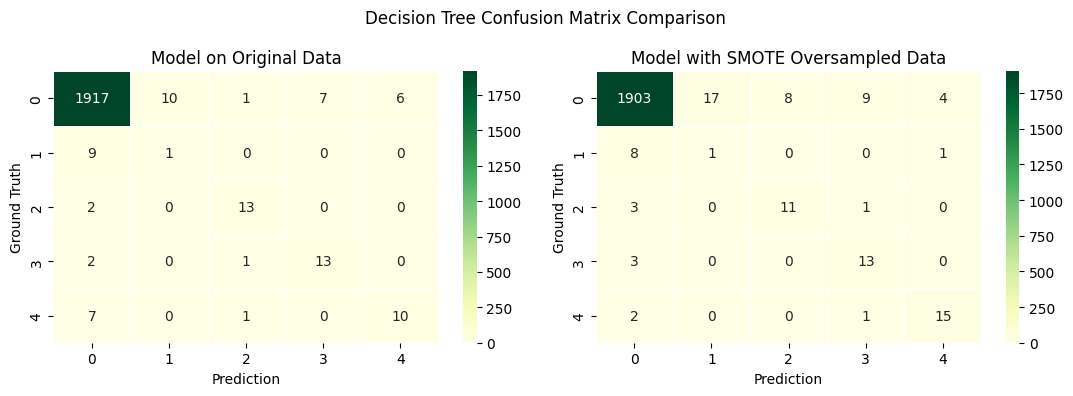

In [47]:
# Train and evaluate both models
# Original model
dt_model = DecisionTreeClassifier(random_state = SEED)
cm_original = evaluate_model(dt_model, X_train, y_train, X_test, y_test, label = "Original Decision Tree Model")

# SMOTE model
dt_smote_model = DecisionTreeClassifier(random_state = SEED)
cm_smote = evaluate_model(dt_smote_model, X_oversampled, y_oversampled, X_test, y_test, label = "SMOTE Oversampled Decision Tree Model")

# Set label names
class_labels = [0, 1, 2, 3, 4]

# Plot confusion matrix comparison
plot_confusion_matrix_comparison(cm_original, cm_smote, labels = class_labels, suptitle = "Decision Tree Confusion Matrix Comparison")

The decision tree model was trained and evaluated on both the original dataset and the SMOTE-oversampled dataset to address class imbalance. Both models achieved high overall accuracy and F1 scores, with the original model performing slightly better in overall accuracy (98% compared to 97%) and weighted F1 score (98% compared to 97%).

Looking at individual classes, the SMOTE model showed improved recall and F1 scores for the minority classes. This means it was more effective at correctly identifying less frequent categories, which is important for capturing all classes accurately. The SMOTE model also had a higher ROC AUC score, indicating stronger overall ability to distinguish between classes.

On the other hand, the original model had better precision and recall for the majority class, which contributed to its higher overall accuracy and weighted metrics. However, this came with weaker performance on the minority classes.

Since the goal is to be both accurate overall and capture all classes well, the SMOTE-oversampled model is a better fit. It improves performance on minority classes without sacrificing much overall accuracy. This balance is key when recognizing all classes reliably while maintaining strong general accuracy.

### Random Forest

Although the oversampled decision tree showed promise, it still had some trouble distinguishing between classes. To improve this, the next step is to try a more advanced algorithm like Random Forest. The plan is to train two Random Forest models: one on the original training set and another using the oversampled data. Comparing the results will help identify which model performs better at class discrimination and overall accuracy.

Random Forest is a machine learning method that builds many decision trees to make predictions. It creates a “forest” where each tree is trained on a different subset of the data. When making a prediction, the model combines the results from all the trees to make a final decision. This helps improve accuracy and reduces the chance of overfitting.


=== ORIGINAL RANDOM FOREST MODEL ===
-------------------
Evaluation metrics:
-------------------
Accuracy: 0.98
F1 Score: 0.98
Precision: 0.98
Recall: 0.98
ROC AUC Score: 0.98
-------------------
Confusion Matrix:
-------------------
[[1937    0    1    3    0]
 [  10    0    0    0    0]
 [   5    0   10    0    0]
 [   4    0    0   12    0]
 [   5    0    0    2   11]]
-------------------
Classification Report:
-------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1941
           1       0.00      0.00      0.00        10
           2       0.91      0.67      0.77        15
           3       0.71      0.75      0.73        16
           4       1.00      0.61      0.76        18

    accuracy                           0.98      2000
   macro avg       0.72      0.61      0.65      2000
weighted avg       0.98      0.98      0.98      2000

-------------------


=== SMOTE OVERSAMPLED RANDOM FOREST MODEL ===
----

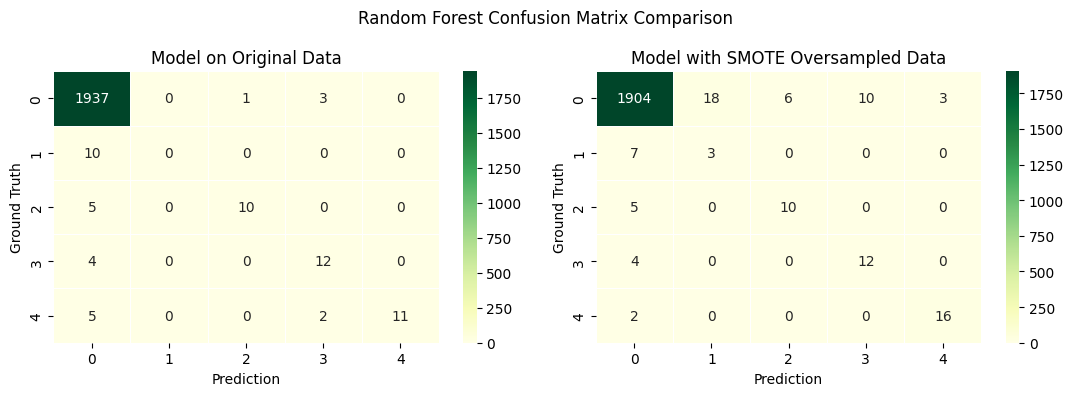

In [48]:
# Train and evaluate both models
# Original model
rf_model = RandomForestClassifier(random_state = SEED)
cm_rf_original = evaluate_model(rf_model, X_train, y_train, X_test, y_test, label = "Original Random Forest Model")

# SMOTE model
rf_smote_model = RandomForestClassifier(random_state = SEED)
cm_rf_smote = evaluate_model(rf_smote_model, X_oversampled, y_oversampled, X_test, y_test, label = "SMOTE Oversampled Random Forest Model")

# Plot confusion matrix comparison
plot_confusion_matrix_comparison(cm_rf_original, cm_rf_smote, labels = class_labels, suptitle = "Random Forest Confusion Matrix Comparison")

The Random Forest models delivered strong overall accuracy with both the original and SMOTE-oversampled data. The original model reached a high accuracy of 0.98 and performed very well on the majority class. However, it struggled to identify the minority classes, showing low recall and F1 scores for those groups. This suggests the model tends to favor the majority class, which is common with imbalanced datasets.

The SMOTE-oversampled model showed a slight decrease in overall accuracy to 0.97 but improved recall and F1 scores for the minority classes. This means it is better at recognizing those harder to predict groups, which is important when balanced performance across all classes is the goal. Precision stayed high, so the oversampled model offers a more balanced classification without sacrificing much overall accuracy.

In conclusion, the SMOTE-oversampled Random Forest model is the better choice because it more effectively captures all classes. It delivers a fairer performance across the dataset, which is key when working with imbalanced data and multiple classes.

### Best Model Selection

The **SMOTE Random Forest model** is the best option for this problem. It offers a strong balance between overall accuracy and the ability to correctly classify all classes, including the minority ones. Although its accuracy is slightly lower than the original models, it achieves better recall and F1 scores for the less frequent classes. The ROC AUC score also confirms its strong predictive performance. This makes the SMOTE Random Forest the most effective choice when balancing accuracy and classification across all classes.

| Model                  | Accuracy | Macro F1 | Minority Class Recall | ROC AUC |
| ---------------------- | -------- | -------- | --------------------- | ------- |
| Original Decision Tree | 0.98     | 0.65     | Low                   | 0.80    |
| SMOTE Decision Tree    | 0.97     | 0.63     | Improved              | 0.82    |
| Original Random Forest | 0.98     | 0.65     | Poor                  | 0.98    |
| SMOTE Random Forest    | 0.97     | 0.66     | Best                  | 0.97    |

## Random Forest Model

Based on the results from the previous models, it’s clear that the **Random Forest** algorithm combined with **SMOTE** oversampling is the better option for this problem. The next step is to tune its hyperparameters to achieve the best possible performance.

### Hyperparameter Tuning

To identify the best hyperparameters for the oversampled Random Forest model, the GridSearchCV module from scikit-learn will be used. This method systematically tests various combinations of hyperparameters to determine the optimal settings that enhance model performance. By employing cross-validation, GridSearchCV ensures that the selected hyperparameters contribute to improved effectiveness in making predictions.

In [49]:
# Define the model
random_forest = RandomForestClassifier(random_state = SEED, class_weight = "balanced")

# Define the parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [50, 75, 100],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 3, 4],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, scoring = "f1_weighted", cv = 3, n_jobs = -1, verbose = 2)

# Fit GridSearchCV
grid_search.fit(X_oversampled, y_oversampled)

# Get best model, parameters and score
best_rf_model = grid_search.best_estimator_
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best Weighted F1 Score from CV: {best_score:.4f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Weighted F1 Score from CV: 0.9967


The best hyperparameters found for the **SMOTE Random Forest Model** are:

- `n_stimators`: 50
- `max_depth`: None
- `min_samples_split`: 2
- `criterion`: gini
- `bootstrap`: False

In [50]:
cm_best = evaluate_model(best_rf_model, X_oversampled, y_oversampled, X_test, y_test, label = "Tuned SMOTE Random Forest")


=== TUNED SMOTE RANDOM FOREST ===
-------------------
Evaluation metrics:
-------------------
Accuracy: 0.97
F1 Score: 0.98
Precision: 0.98
Recall: 0.97
ROC AUC Score: 0.97
-------------------
Confusion Matrix:
-------------------
[[1909   17    6    6    3]
 [   7    3    0    0    0]
 [   6    0    9    0    0]
 [   4    0    0   12    0]
 [   2    0    0    0   16]]
-------------------
Classification Report:
-------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1941
           1       0.15      0.30      0.20        10
           2       0.60      0.60      0.60        15
           3       0.67      0.75      0.71        16
           4       0.84      0.89      0.86        18

    accuracy                           0.97      2000
   macro avg       0.65      0.70      0.67      2000
weighted avg       0.98      0.97      0.98      2000

-------------------



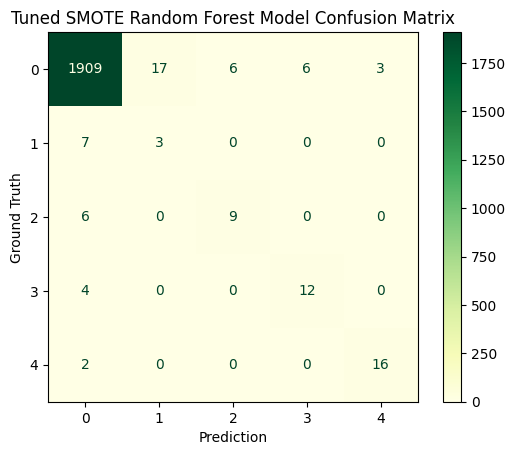

In [51]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm_best, display_labels = class_labels)
disp.plot(cmap = "YlGn", values_format = "d")
plt.title("Tuned SMOTE Random Forest Model Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.savefig(FIGURES_DIR / "model" / "Best-random-forest-model-confusion-matrix.png");

The **tuned SMOTE Random Forest model** shows a small improvement over the original version. Overall accuracy and weighted metrics remain the same, but the model handles some of the smaller classes better after tuning.

Class 1 and class 3 show noticeable gains in F1 score, and class 4 also improves. The macro average F1 score increases slightly, which suggests the model is doing a better job at balancing predictions across all classes.

Although class 1 remains difficult to predict, the tuning helps strengthen performance where it matters most. Based on these results, the tuned version is a better fit for this task.

| Metric             | SMOTE RF (original) | SMOTE RF (tuned) |
| ------------------ | ------------------- | ---------------- |
| Accuracy           | 0.97                | 0.97             |
| Weighted F1 Score  | 0.98                | 0.98             |
| Weighted Precision | 0.98                | 0.98             |
| Weighted Recall    | 0.97                | 0.97             |
| ROC AUC            | 0.97                | 0.97             |
| Macro F1 Score     | 0.66                | 0.67             |
| Class 1 F1 Score   | 0.07                | 0.20             |
| Class 2 F1 Score   | 0.65                | 0.60             |
| Class 3 F1 Score   | 0.63                | 0.71             |
| Class 4 F1 Score   | 0.79                | 0.86             |

In [52]:
# Save the trained model as pickle format
with open(MODEL_DIR / "Best-random-forest-model.pkl", "wb") as file:
    pickle.dump(best_rf_model, file)

## Model Performance

### Feature Importance

Understanding which features matter most is an important part of machine learning. It helps make the model easier to interpret by showing which factors influence predictions. It also allows us to simplify the data by removing features that don’t add value, which can improve model accuracy and reduce the risk of overfitting. Overall, knowing feature importance makes the model more efficient and useful.

The graph clearly shows that the most influential features are **torque, tool wear, and rotational speed**. Meanwhile, process temperature and product quality have little impact on the model’s predictions.

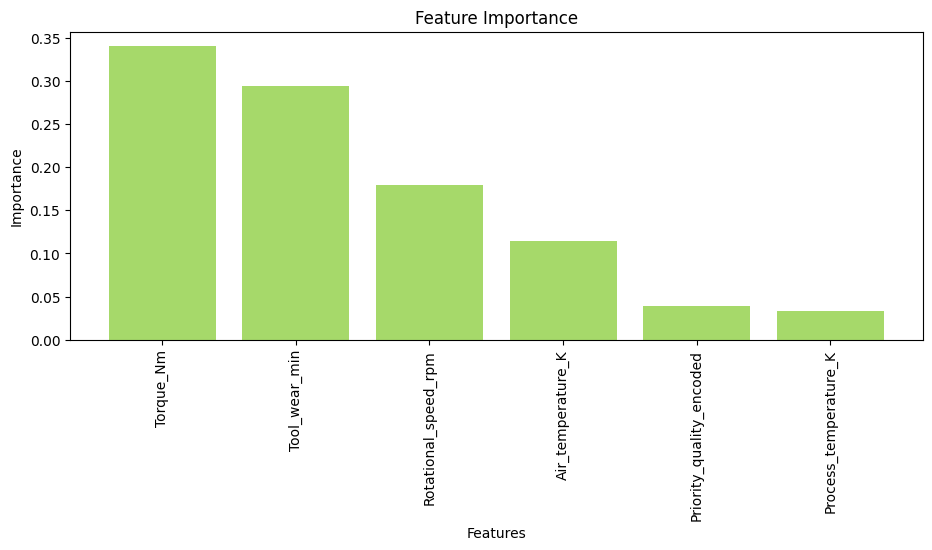

In [53]:
# Calculate feature importances
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
feature_importance_graph = plt.figure(figsize = (11, 4))
plt.bar(range(X_oversampled.shape[1]), importances[indices], align = "center", color = "#a6d96a")
plt.xticks(range(X_oversampled.shape[1]), X_oversampled.columns[indices], rotation = 90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.savefig(FIGURES_DIR / "model" / "Random-forest-feature-importance.png")

### ROC AUC Curve

The Receiver Operating Characteristic (ROC) curve is a helpful way to evaluate a classification model’s performance. It shows the relationship between the true positive rate and the false positive rate at different thresholds. This helps us understand how well the model can tell positive and negative classes apart. The area under the curve (AUC) summarizes this performance in a single number: an AUC of 1 means perfect classification, while an AUC of 0.5 means the model cannot distinguish between classes better than random guessing.

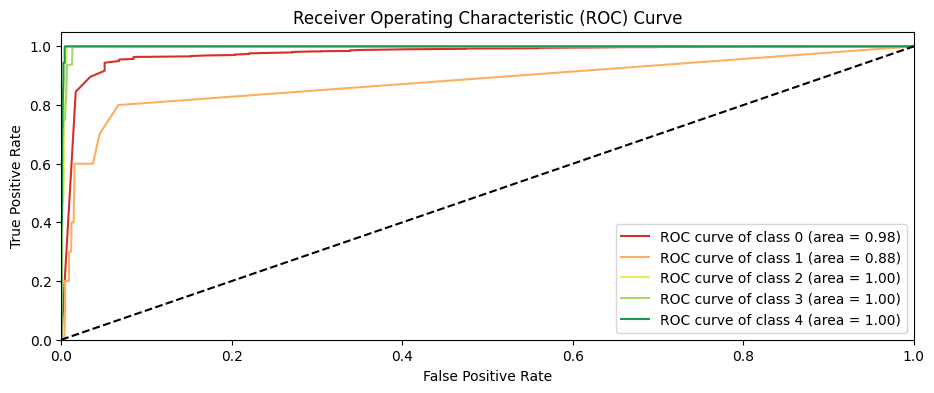

In [54]:
# Binarize the output
y_bin = label_binarize(y_test, classes = [0, 1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], best_rf_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ["#d73027", "#fdae61", "#eaea5b", "#a6d96a", "#1a9850"]

# Plot ROC curves
plt.figure(figsize = (11, 4))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color =colors[i], label = "ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc = "lower right")
plt.savefig(FIGURES_DIR / "model" / "Random-forest-roc-curve.png")

### Precision-Recall Curve

The precision-recall curve is a useful tool for evaluating a classification model. It shows the trade-off between precision and recall at different threshold levels.

* **Precision** measures the accuracy of positive predictions (true positives divided by total predicted positives).
* **Recall** measures how well the model identifies true positive cases (true positives divided by total actual positives).

The curve plots precision on the y-axis and recall on the x-axis. This makes it especially helpful when dealing with imbalanced classes.

From the graph, it’s clear that class 1 has the lowest precision-recall balance. In contrast, class 0 shows a nearly perfect balance, while the other classes follow a similar pattern.

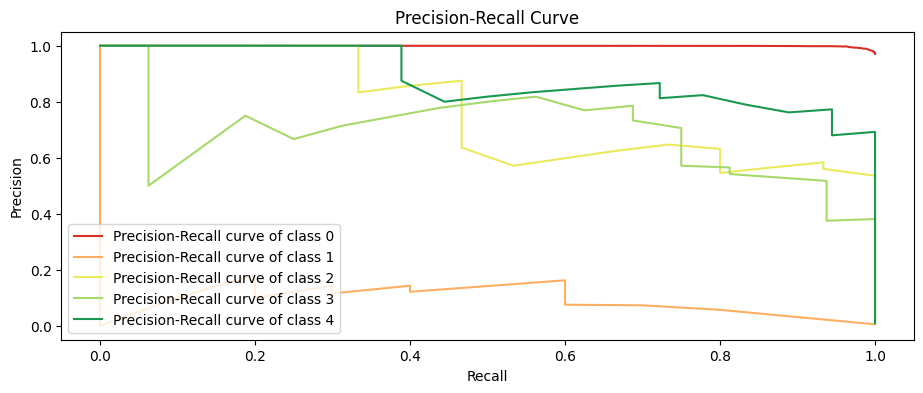

In [55]:
plt.figure(figsize = (11, 4))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], best_rf_model.predict_proba(X_test)[:, i])
    plt.plot(recall, precision, color = colors[i], label = "Precision-Recall curve of class {0}".format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc = "lower left")
plt.savefig(FIGURES_DIR / "model" / "Random-forest-model-precision-recall-curve.png")

## Robustness Testing with Cross-Validation

To ensure the model’s performance is reliable and not dependent on a specific train-test split, a robustness test was conducted using cross-validation. This method repeatedly trains and evaluates the model on different subsets of the data, providing a more comprehensive view of its generalization ability. The weighted F1 score was chosen as the main metric to balance accuracy and class-wise performance, reflecting the overall effectiveness of the model across all classes.

In [56]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# Define repeated stratified K-fold CV
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = SEED)

# Evaluate the model using weighted F1 score
scores = cross_val_score(best_rf_model, X_oversampled, y_oversampled, 
                         scoring = "f1_weighted", cv = cv, n_jobs = -1)

# Print results
print(f"Cross-validated weighted F1 scores: {scores}")
print(f"Mean weighted F1 score: {scores.mean():.4f}")
print(f"Standard deviation: {scores.std():.4f}")

Cross-validated weighted F1 scores: [0.99701794 0.99701965 0.99675852 0.99728039 0.99598031 0.99676105
 0.9971495  0.99675804 0.99740906 0.99611044 0.99571871 0.99701955
 0.99649796 0.99753831 0.99676042]
Mean weighted F1 score: 0.9968
Standard deviation: 0.0005


The cross-validation results show a consistently high weighted F1 score, with an average of 0.9968 and a very low standard deviation of 0.0005. This indicates the model performs reliably across different data splits and is unlikely to be overfitting or underperforming on unseen data. The strong and stable performance confirms the model’s robustness, making it a solid choice for deployment. With this confidence, the next step is to focus on explainability to better understand the model’s decisions.

## SHAP Explainability

This section offers insights into how the final **Random Forest** model makes predictions using **SHAP (SHapley Additive exPlanations)**. The analysis is based on the **test set** and helps understand both overall (global) and individual (local) model behavior.

Since the model was trained on SMOTE-enhanced data, the same data is used for explanations to keep things consistent.

### What is SHAP?

SHAP is a tool that helps interpret machine learning models. It assigns a value to each feature to show how much that feature contributed to a prediction. In a multiclass model, SHAP provides separate explanations for each class. This way, it’s possible to see not only which features matter most, but also how they influence the model’s confidence in each class.

There are two types of explanations:

* **Global explanations** highlight which features are most important across all predictions.
* **Local explanations** reveal how specific features affected the prediction for a single example.

### Global Explanation

Global SHAP analysis helps identify which features generally drive predictions across all samples. It is useful for understanding overall feature importance and their influence direction.

In [57]:
# Create TreeExplainer for the Random Forest model
explainer = shap.Explainer(best_rf_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

#### General summary plot

This summary bar plot displays the average impact of each feature on the model’s predictions across all classes. Features are ranked by their overall influence. The top three features with the strongest impact are:

- Torque
- Tool Wear
- Rotational Speed

These three features consistently show the strongest impact on the model's output.

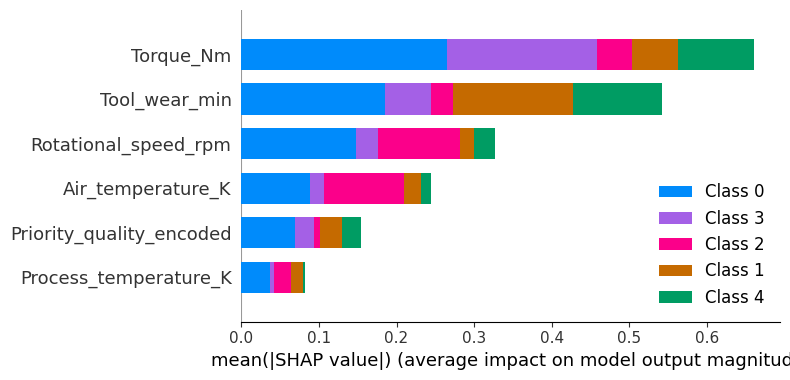

In [58]:
# Plot shap general summary
shap.summary_plot(shap_values, X_test, show = True) # show = False doesn't display the plot in the notebook but helps matplotlib save the fig. 
                                                            # Set to True if you want to display the plot in the notebook

# Save the plot
fig = plt.gcf() 
plt.savefig(FIGURES_DIR / "shap_summary_plot.png", bbox_inches = "tight")
plt.close(fig)

#### Per-Class Global Feature Importance

To better understand how the model behaves for each class, a summary plot is created for every individual class. This reveals which features have the most influence on that specific category. In the plots, red dots represent high feature values, while blue dots represent low ones. Below is a summary of the key insights.

- **Class 0:**
    - Torque is the most important feature.
    - Intermediate to high torque values increase the likelihood of this class.
    - Tool wear also influences predictions, but less strongly, pushing the prediction up at low to mid-range values.

- **Class 1:**
    - Tool wear is the top feature for this class.
    - Generally, tool wear contributes negatively to predicting class 1, but high values push the prediction positively.
    - Torque is the second most influential feature and acts opposite to tool wear: low to mid-range torque values increase the prediction for class 1.

- **Class 2:**
    - Rotational speed is the most important feature.
    - Its effect is mostly mild and negative, especially at lower values.
    - Air temperature also has a mild influence, pushing the prediction up at high values.

- **Class 3:**
  - Torque is the key feature.
  - Low to mid-range torque values tend to decrease the prediction for this class, while high values increase it.
  - Tool wear has a mild positive influence when its values are low or mid-range.

- **Class 4:**
  - Tool wear is the most important feature.
  - It mildly increases the prediction when its values are high.
  - Torque shows a similar influence, pushing predictions up at high values.

In [59]:
class_names = best_rf_model.classes_
feature_names = X_test.columns

# Plot summary charts per class
for i, class_name in enumerate(class_names):
    print(f"=== SHAP Summary Plot for Class {class_name} ===")
    shap.summary_plot(shap_values.values[:, :, i], X_test, show = False) # Set to True if you want to display the plot in the notebook

    # Save the plot
    fig = plt.gcf()
    plt.title(f"SHAP Summary Plot - Class {class_name}")
    plt.savefig(FIGURES_DIR / f"shap_summary_class_{class_name}.png", bbox_inches = "tight")
    plt.close(fig)

=== SHAP Summary Plot for Class 0 ===
=== SHAP Summary Plot for Class 1 ===
=== SHAP Summary Plot for Class 2 ===
=== SHAP Summary Plot for Class 3 ===
=== SHAP Summary Plot for Class 4 ===


- **Bar Charts:**

To make these findings easier to understand and more visually clear, bar charts are created for each class. They show the importance of each feature, sorted by impact.

Before plotting the bar charts, the **mean absolute SHAP values per feature per class** are calculated. This step quantifies the average impact of each feature for every class and provides a structured view of feature importance across classes.

In [60]:
# Collect mean absolute shap values per class
shap_class_feature_data = {
    f"Class_{class_names[i]}": np.abs(shap_values.values[:, :, i]).mean(axis = 0)
    for i in range(len(class_names))
}

# Convert to DataFrame
shap_feature_importance_df = pd.DataFrame(shap_class_feature_data, index = feature_names)

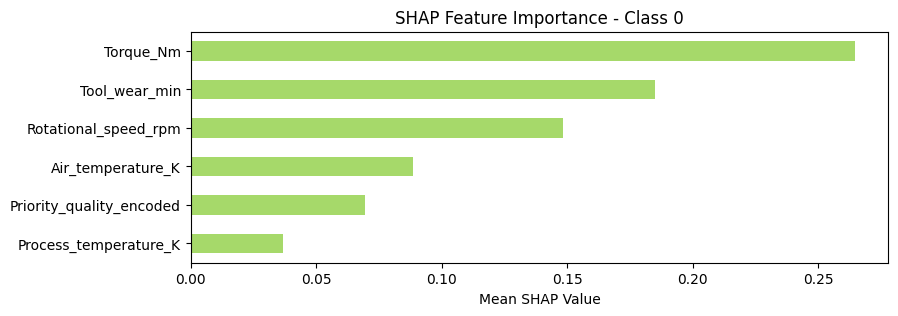

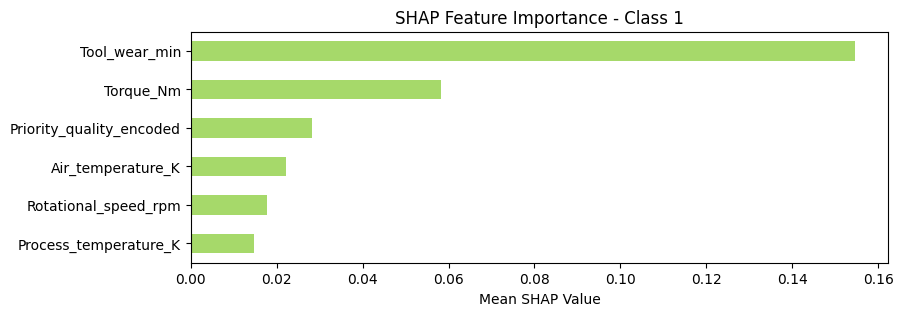

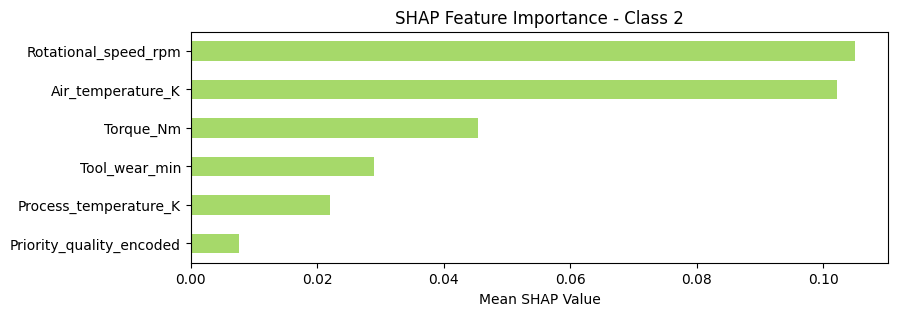

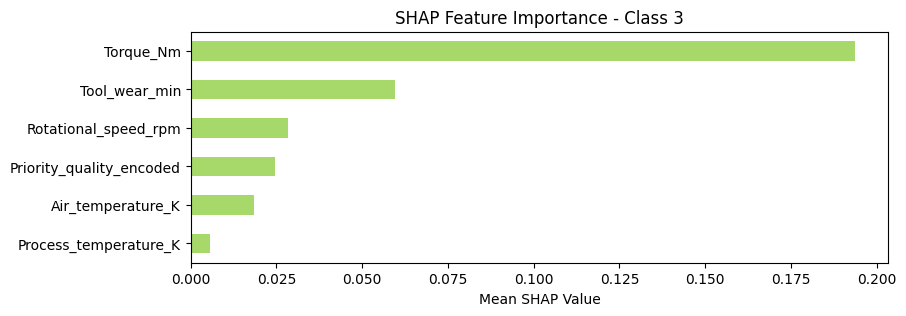

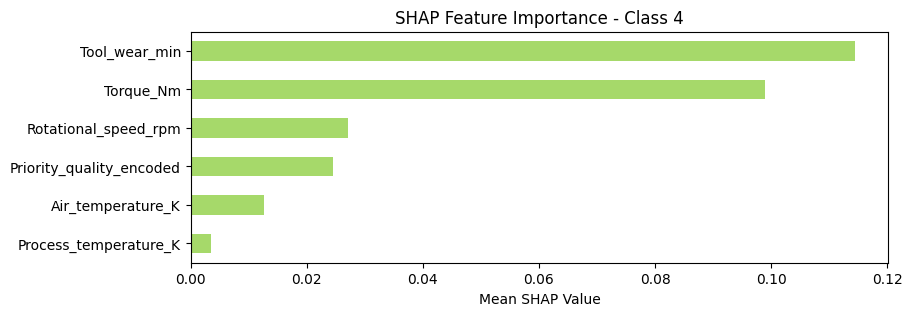

In [61]:
# Plot mean shap value per feature per class
for class_name in shap_feature_importance_df.columns:
    df_sorted = shap_feature_importance_df[class_name].sort_values(ascending = True)
    
    plt.figure(figsize = (9, 3))
    df_sorted.plot(kind = "barh", color = "#a6d96a")
    plt.title(f"SHAP Feature Importance - {class_name.replace('_', ' ')}")
    plt.xlabel("Mean SHAP Value")
    plt.show()

- **Heatmap:**

This heatmap shows the overall contribution of each feature to every class.

Text(0.5, 1.0, 'Heatmap: SHAP Feature Importance by Class')

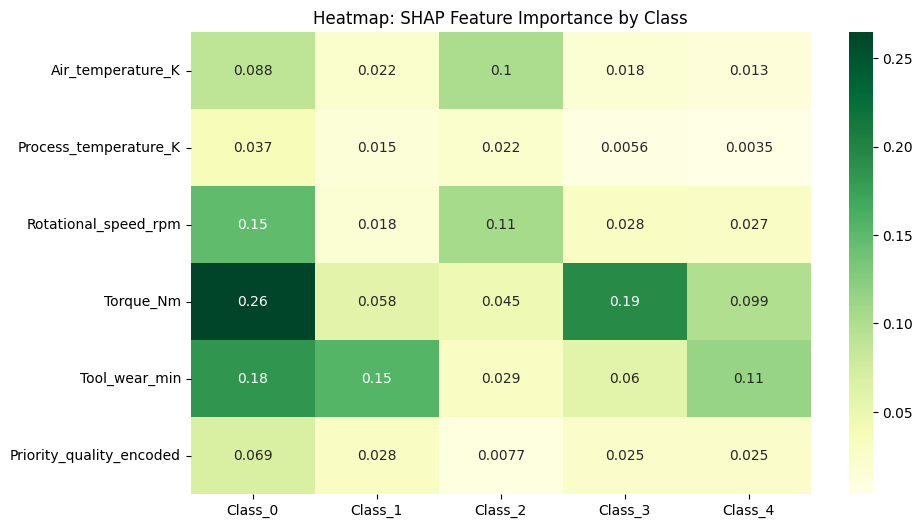

In [62]:
# Plot heatmap
plt.figure(figsize = (10, 6))
sns.heatmap(shap_feature_importance_df, annot = True, cmap = "YlGn")
plt.title("Heatmap: SHAP Feature Importance by Class")

### Per-Class Feature Trends (Scatter Analysis)

To explore the behavior and trends of each feature in more detail, a scatter analysis is performed. For this, the SHAP values and actual values of the top three features per class are plotted. This helps clearly and effectively show how feature values influence SHAP values, which in turn affect the model’s prediction for each class.

- **Class 0:**
  - **Torque:** Values below 15 and above 60 show negative SHAP values, lowering the prediction for this class.
  - **Tool wear:** High values (above 200) negatively impact the prediction.
  - **Rotational speed:** Mid-range values tend to increase the likelihood of this class.

- **Class 1:**
  - **Tool wear:** High values (above 200) drive the prediction of class 1.
  - **Torque:** Mid-range values push the prediction up.
  - **Product quality (encoded):** Some values of quality 0 slightly increase the prediction for this class.

- **Class 2:**
  - **Rotational speed:** Low values increase the prediction for class 2.
  - **Air temperature:** Low values reduce the prediction of this class.
  - **Torque:** Mid-range values (around 40 to 60) positively influence the prediction.

- **Class 3:**
  - **Torque:** Values below 15 and above 60 contribute positively to the prediction.
  - **Tool wear:** Values below 175 tend to push the prediction up.
  - **Rotational speed:** Mostly high values influence the prediction positively.

- **Class 4:**
  - **Tool wear:** High values (above 175) increase the prediction for this class.
  - **Torque:** High values (above 50) also have a positive effect.
  - **Rotational speed:** Low values drive the prediction of class 4.

In [63]:
# Reset index to align with shap_df
X_test_reset = X_test.reset_index(drop = True)

# Build DataFrame with SHAP + actual feature values
shap_df = pd.DataFrame([
    {
        "sample_index": i,
        "feature_name": feature_names[j],
        "class_name": class_names[k],
        "shap_value": shap_values.values[i, j, k],
        "feature_value": X_test_reset.iloc[i, j]
    }
    for i in range(X_test.shape[0])
    for j in range(len(feature_names))
    for k in range(len(class_names))
])

=== Scatter Plots for Class 0 ===


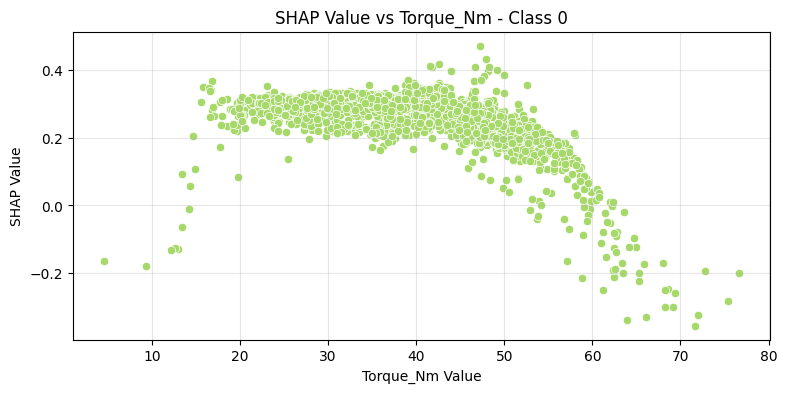

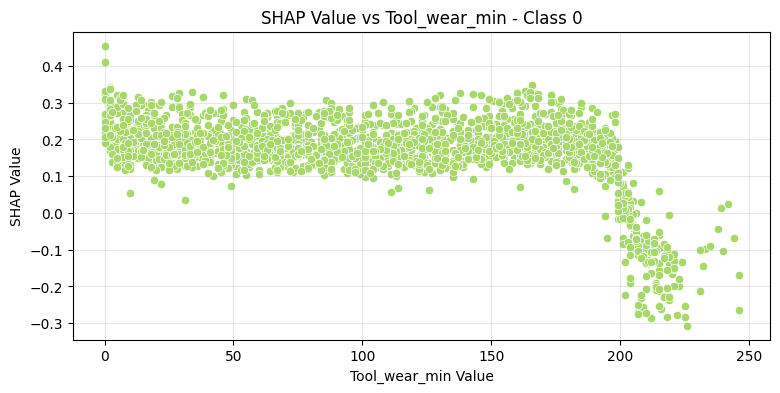

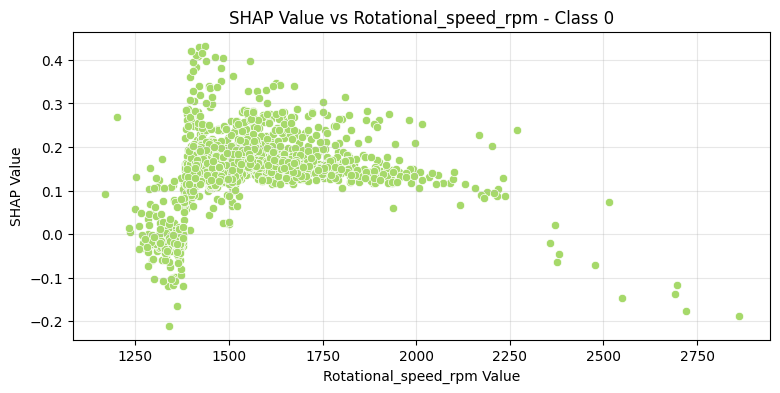

=== Scatter Plots for Class 1 ===


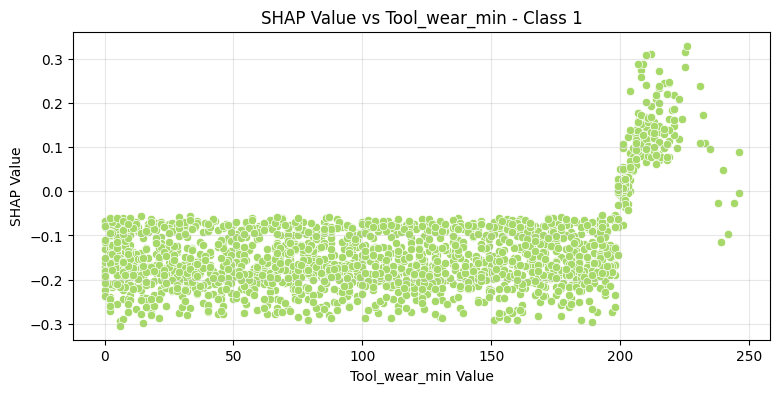

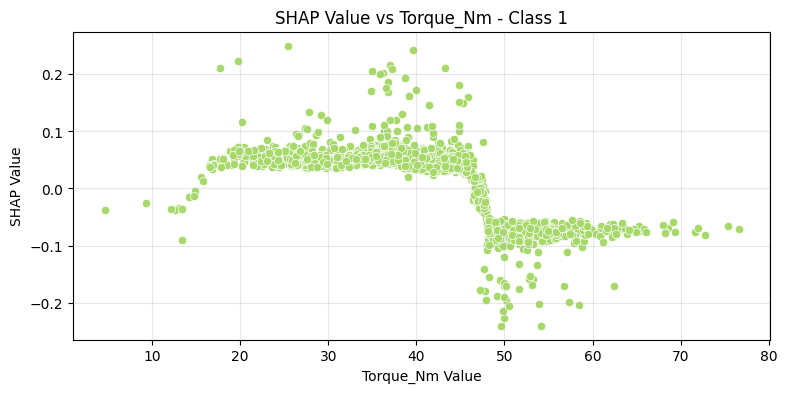

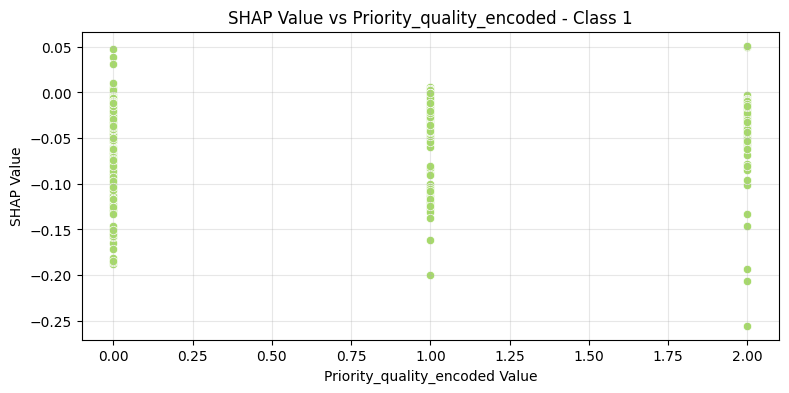

=== Scatter Plots for Class 2 ===


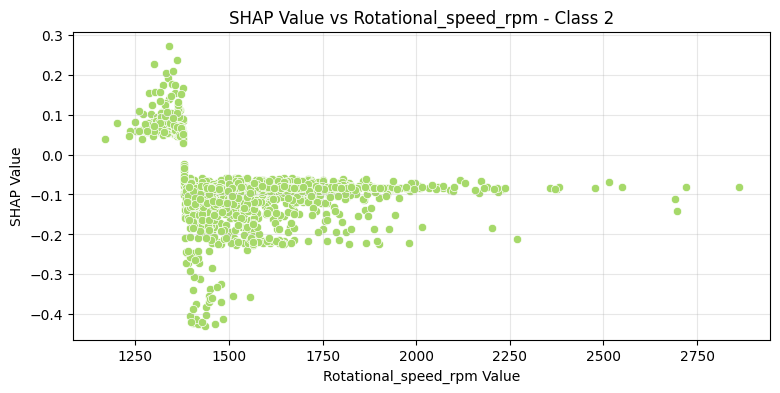

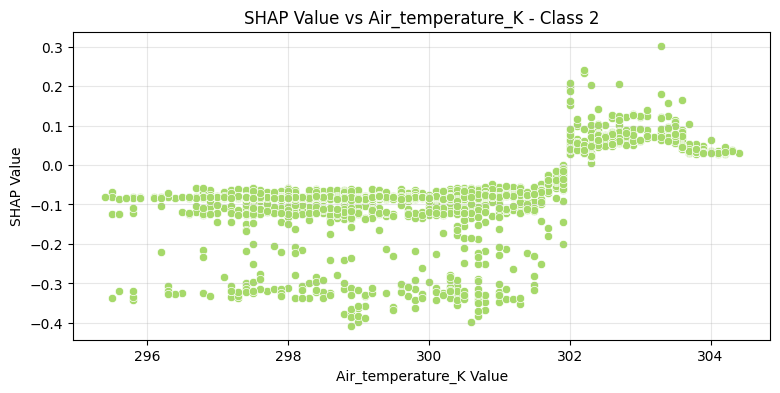

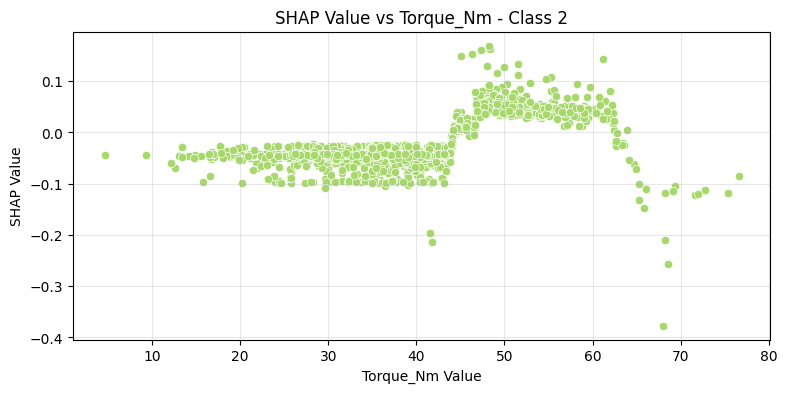

=== Scatter Plots for Class 3 ===


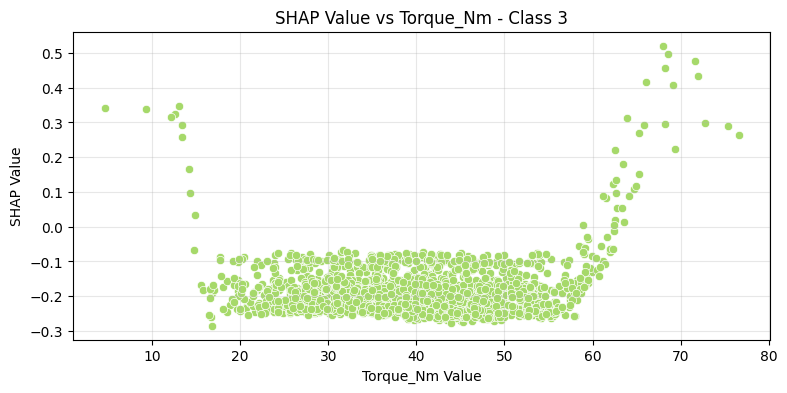

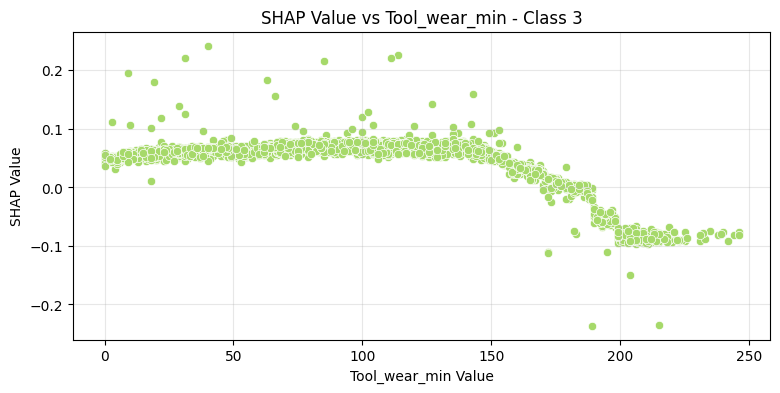

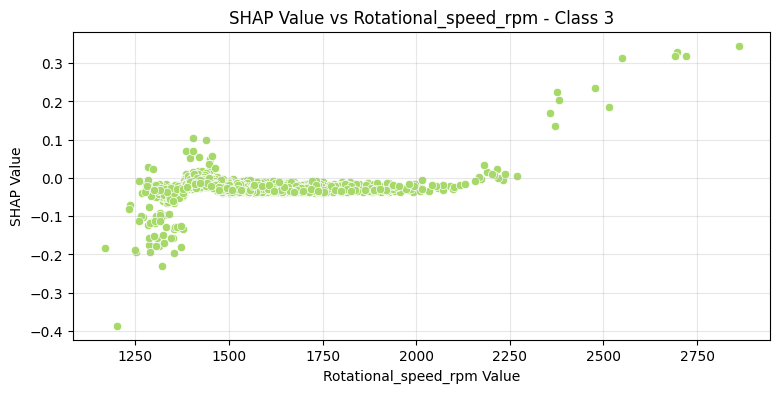

=== Scatter Plots for Class 4 ===


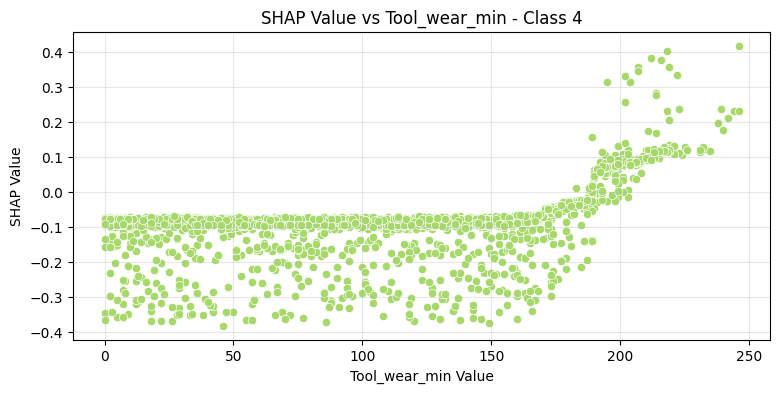

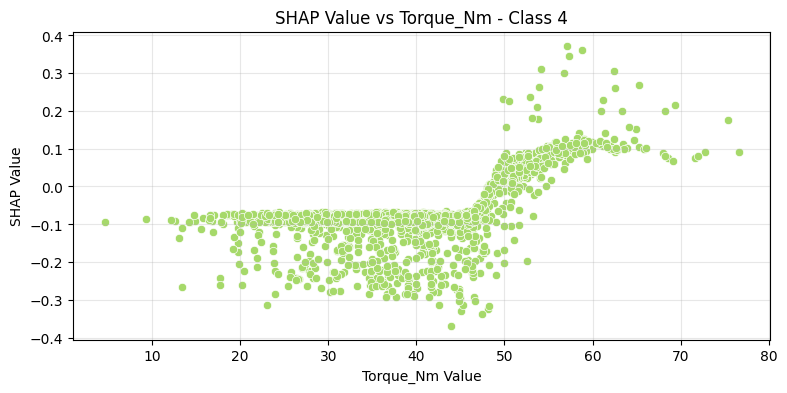

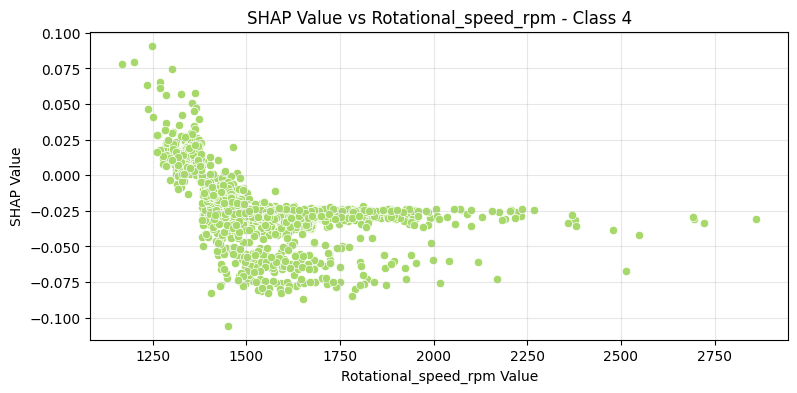

In [64]:
# Plot top 3 features per class
top_n = 3

top_features_per_class = {
    class_name: shap_feature_importance_df[f"Class_{class_name}"]
                    .sort_values(ascending=False)
                    .head(top_n).index.tolist()
    for class_name in class_names
}

for class_name in class_names:
    print(f"=== Scatter Plots for Class {class_name} ===")
    top_features = top_features_per_class[class_name]
    
    for feature in top_features:
        df_plot = shap_df[
            (shap_df["class_name"] == class_name) & 
            (shap_df["feature_name"] == feature)
        ]
        
        plt.figure(figsize = (9, 4))
        sns.scatterplot(data = df_plot, x = "feature_value", y = "shap_value", color = "#a6d96a")
        plt.title(f"SHAP Value vs {feature} - Class {class_name}")
        plt.xlabel(f"{feature} Value")
        plt.ylabel("SHAP Value")
        plt.grid(True, alpha = 0.3)
        plt.show()

### Local Explanations

To understand how the model makes decisions on individual predictions, SHAP is used to break down the impact of each feature for specific samples. This is known as a **local explanation**.

For this analysis, one correct and one incorrect prediction is selected for each class. SHAP waterfall plots are used to visualize how each feature influenced the model's decision, either pushing the prediction toward or away from a given class. These plots show how the model’s base value is adjusted by each feature to reach the final output.

In [65]:
# Get predicted classes
y_pred = best_rf_model.predict(X_test)

# Create a DataFrame with predictions
results_df = X_test.copy()
results_df["true_label"] = y_test.values
results_df["predicted_label"] = y_pred

# Store sample indices
sample_indices = {}

# For each class, get one correct and one incorrect prediction
for class_label in best_rf_model.classes_:
    correct = results_df[
        (results_df["true_label"] == class_label) &
        (results_df["predicted_label"] == class_label)
    ]
    incorrect = results_df[
        (results_df["true_label"] == class_label) &
        (results_df["predicted_label"] != class_label)
    ]
    
    if not correct.empty:
        correct_idx = correct.index[0]
    else:
        correct_idx = None
        
    if not incorrect.empty:
        incorrect_idx = incorrect.index[0]
    else:
        incorrect_idx = None
    
    sample_indices[class_label] = {
        "correct": correct_idx,
        "incorrect": incorrect_idx
    }

sample_indices

{0: {'correct': 6252, 'incorrect': 5653},
 1: {'correct': 6340, 'incorrect': 5309},
 2: {'correct': 3787, 'incorrect': 4851},
 3: {'correct': 4071, 'incorrect': 1123},
 4: {'correct': 3350, 'incorrect': 1833}}

SHAP Waterfall Plot — Class 0 (correct prediction)


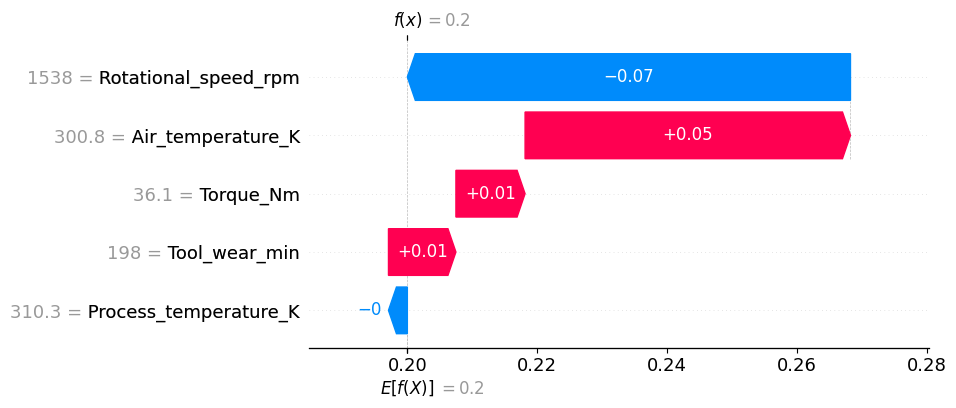

SHAP Waterfall Plot — Class 0 (incorrect prediction)


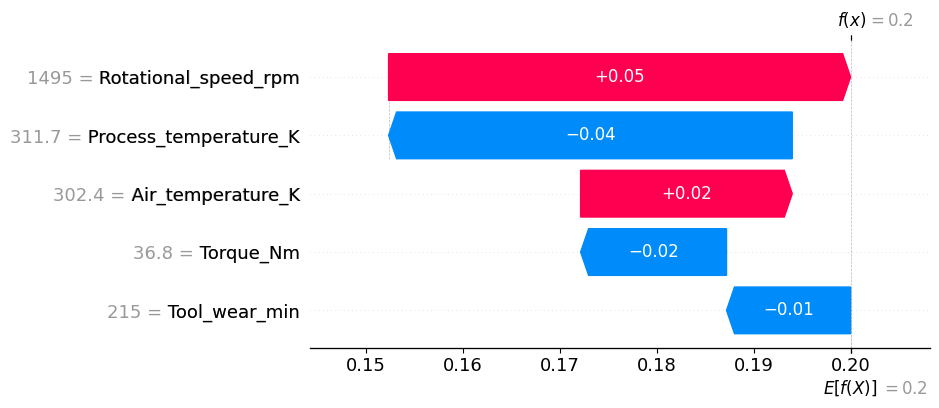

SHAP Waterfall Plot — Class 1 (correct prediction)


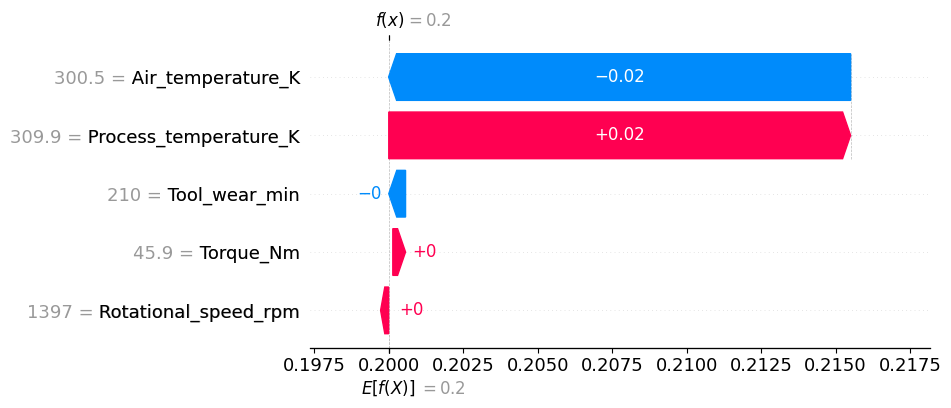

SHAP Waterfall Plot — Class 1 (incorrect prediction)


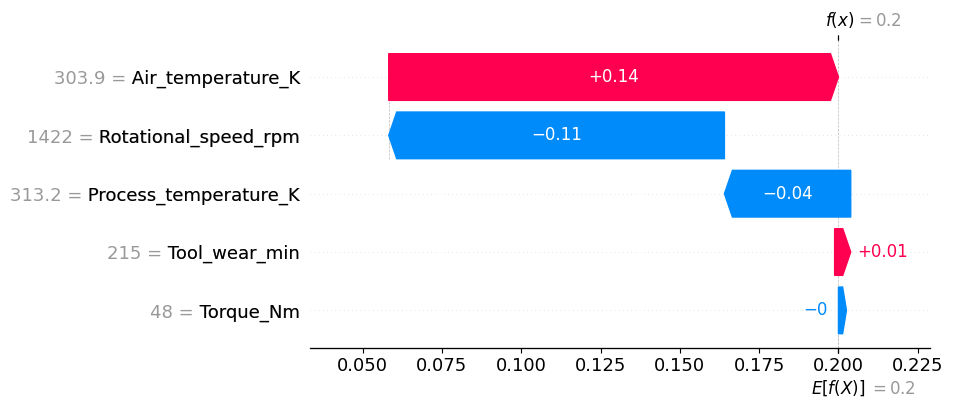

SHAP Waterfall Plot — Class 2 (correct prediction)


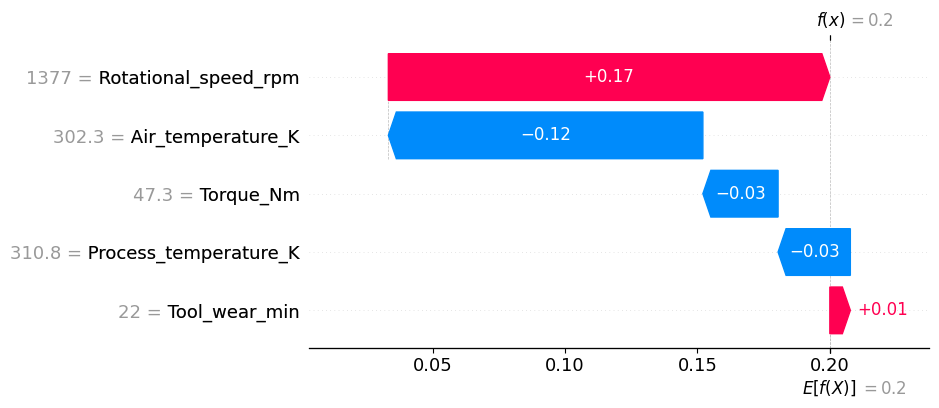

SHAP Waterfall Plot — Class 2 (incorrect prediction)


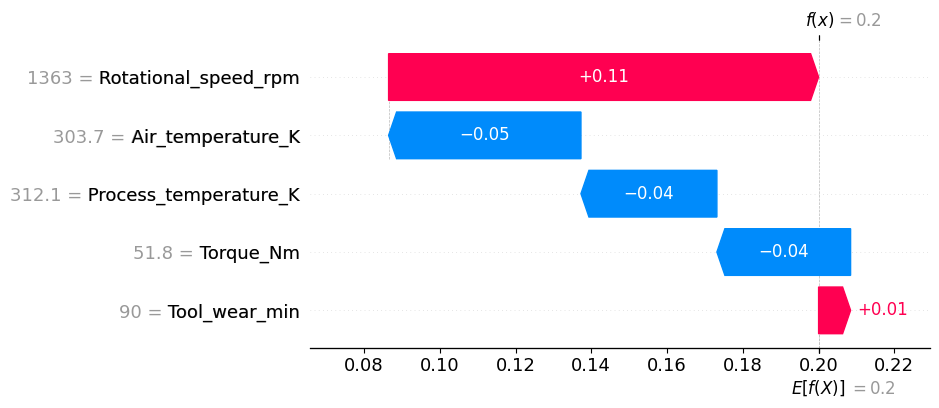

SHAP Waterfall Plot — Class 3 (correct prediction)


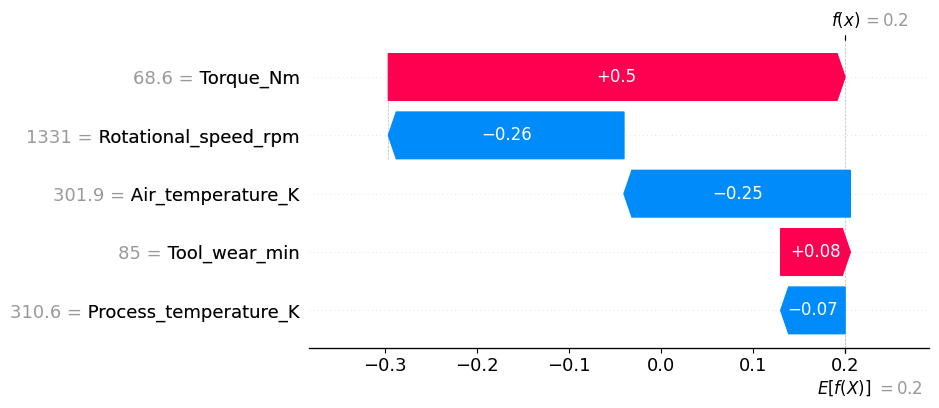

SHAP Waterfall Plot — Class 3 (incorrect prediction)


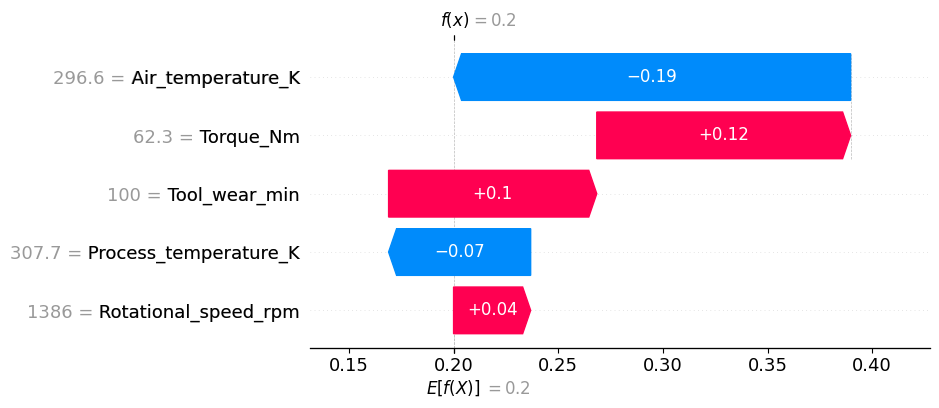

SHAP Waterfall Plot — Class 4 (correct prediction)


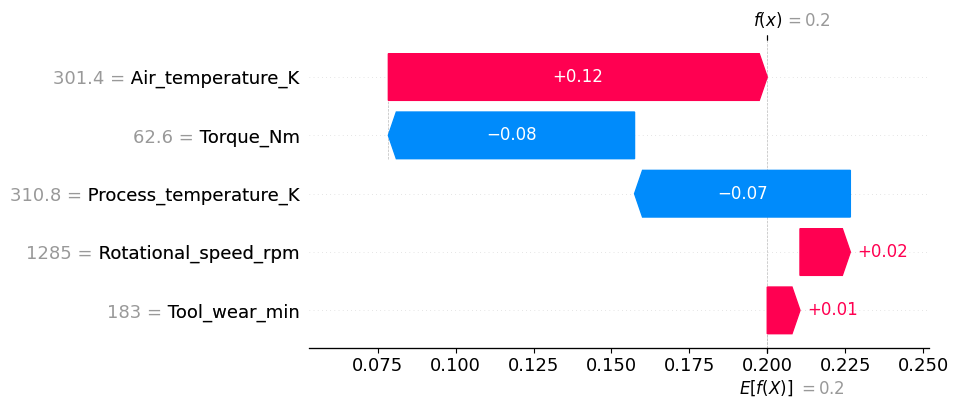

SHAP Waterfall Plot — Class 4 (incorrect prediction)


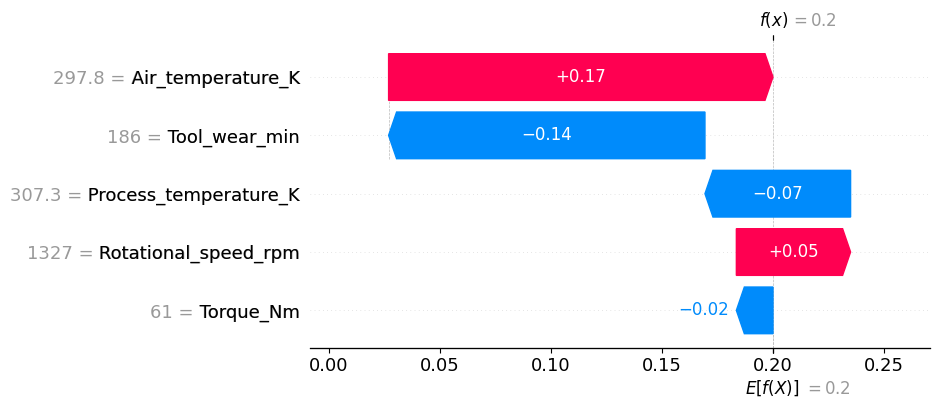

In [66]:
for class_label, indices in sample_indices.items():
    for outcome_type, sample_idx in indices.items():
        if sample_idx is None or sample_idx not in X_test.index:
            print(f"Skipping {outcome_type} sample for class {class_label} (not found or invalid index)")
            continue

        print(f"SHAP Waterfall Plot — Class {class_label} ({outcome_type} prediction)")

        shap_values_single = explainer(X_test.loc[[sample_idx]])

        try:
            explanation = shap.Explanation(
                values = shap_values_single.values[0, class_label],
                base_values = shap_values_single.base_values[0, class_label],
                data = shap_values_single.data[0],
                feature_names = shap_values_single.feature_names
            )
            shap.plots.waterfall(explanation)
        except Exception as e:
            print(f"Error plotting SHAP for class {class_label}: {e}")

From the waterfall plots of correct and incorrect predictions for each class, these are the results obtained:

- **Class 0:**

Predictions rely on **tool wear, torque, and air temperature**. In correct cases, moderate air temperature and low torque support class 0. In incorrect ones, small increases in tool wear or torque reverse their influence, leading to misclassification. Rotational speed also flips behavior, suggesting the model is too sensitive to small input changes and struggles with feature interactions.

- **Class 1:**

This class is underrepresented, making it hard for the model to learn consistent patterns. Tool wear is usually a negative signal but sometimes appears as positive in rare cases. The model overweights these exceptions, causing unstable predictions and low accuracy.

- **Class 2:**

The model focuses on **tool wear, rotational speed, and air temperature**. In correct predictions, high tool wear and temperature reduce confidence, but in incorrect ones, the model misinterprets them as positive. This points to overfitting on rare combinations and difficulty capturing non-linear effects.

- **Class 3:**

Predictions are driven by **torque and tool wear** (positive) and **temperature** (negative). Rotational speed behaves inconsistently, sometimes switching roles between correct and incorrect predictions. This inconsistency suggests the model misses threshold effects and fails to generalize in some regions.

- **Class 4:**

**Air temperature and rotational speed** are reliable signals, but **tool wear** behaves unpredictably. Small changes can flip its influence. The model is also sensitive to shifts in **process temperature and torque**, which affects prediction stability.

In summary:

- The model relies on core features like **tool wear, torque, rotational speed, and temperature**, but behaves inconsistently in edge cases.
- **Small input changes**, especially in tool wear and torque, can flip predictions.
- **Rotational speed** shows unstable effects, likely due to missed interactions or thresholds.
- **Underrepresented classes** suffer from overfitting to rare patterns.
- Better **feature engineering**, **regularization**, and **handling of class imbalance** can improve model stability and accuracy.

### Model Behavior Summary

The analysis draws on global feature importance, scatter plots, and SHAP waterfall charts. Together, these highlight which features influence predictions, how they behave across value ranges, and where the model tends to fail. The three sources align closely and offer complementary insights.

**Class 0**

- **Key drivers:** Torque is the most important feature. Mid to high torque values increase prediction confidence. Tool wear and air temperature also contribute positively at moderate levels.
- **Scatter trends:** Prediction confidence decreases at torque values below 15 or above 60. Tool wear above 200 and extreme rotational speed values lower confidence.
- **SHAP behavior:** Small increases in torque or tool wear can reverse their contribution. Rotational speed shifts direction across cases, indicating weak interaction modeling.
- **Summary:** The model uses appropriate signals but is highly sensitive to small input variations.

**Class 1**

- **Key drivers:** Tool wear generally reduces prediction confidence but reverses at high values. Torque at low to mid levels contributes positively.
- **Scatter trends:** High tool wear (above 200) and mid-range torque are associated with class 1 predictions. Some product quality values show a mild positive influence.
- **SHAP behavior:** Infrequent examples with high tool wear are overemphasized, leading to inconsistent and inaccurate predictions.
- **Summary:** Underrepresentation leads to unstable model behavior and poor generalization for class 1.

**Class 2**

- **Key drivers:** Rotational speed shows a mild negative effect. Air temperature contributes positively at high values. Tool wear has limited impact.
- **Scatter trends:** Low rotational speed and moderate torque support predictions. Low air temperature reduces confidence.
- **SHAP behavior:** In certain errors, high tool wear and air temperature are misinterpreted, suggesting overfitting and unmodeled non-linear effects.
- **Summary:** Predictive signals are mostly correct, but the model generalizes poorly in edge cases.

**Class 3**

- **Key drivers:** Torque is the dominant signal. High values increase prediction confidence. Tool wear adds a mild positive effect.
- **Scatter trends:** High torque and low tool wear support predictions. Rotational speed also shows a positive trend.
- **SHAP behavior:** Rotational speed switches direction across correct and incorrect cases. Low torque and cold air reduce confidence, leading to misclassification.
- **Summary:** The model performs well with key features but behaves inconsistently with rotational speed.

**Class 4**

- **Key drivers:** Tool wear, torque, and rotational speed all contribute positively, especially at higher values.
- **Scatter trends:** Tool wear above 175, torque above 50, and low rotational speed support predictions.
- **SHAP behavior:** Predictions are highly sensitive near the class boundary. Small changes in tool wear, torque, or temperature lead to shifts in prediction direction.
- **Summary:** Signals are appropriate, but decision boundaries are fragile, especially near threshold values.

**Overall Findings**

- The model consistently uses **tool wear**, **torque**, and **rotational speed** as key features.
- **Temperature-related features** show stable and predictable behavior.
- **Small variations** in tool wear and torque frequently cause reversals in prediction direction.
- **Underrepresented classes** result in overfitting to rare patterns.
- **Rotational speed** lacks consistent influence, indicating missing interactions or thresholds.

These patterns indicate that improvements in feature interaction modeling, regularization, and class balancing would enhance model stability and generalization.

## Conclusions

The objective of this project was to build a predictive model using decision tree and random forest algorithms to detect failures in an industrial milling machine.

A key challenge was the class imbalance in the dataset, which affected model performance. To address this, the SMOTE technique was applied to oversample the minority classes.

Four models were developed: decision tree and random forest, both with and without oversampling. The random forest model with SMOTE performed best overall, especially in distinguishing between classes. However, class 1 remained difficult to classify. Hyperparameter tuning improved the model’s performance, particularly for class 1, as reflected in higher F1, precision, and recall scores. Further optimization is still required to enhance prediction accuracy for minority classes.

SHAP analysis confirmed that the model relies on relevant features such as tool wear, torque, rotational speed, and temperature. However, it also revealed several issues. The model is overly sensitive to small input changes, especially in tool wear and torque, which causes prediction instability. Rotational speed showed inconsistent behavior across classes, indicating gaps in how feature interactions are handled. For underrepresented classes, the model tends to overfit to rare patterns, reducing generalization and accuracy.

## Future Work

Further improvements can be made by exploring advanced algorithms such as XGBoost, which may offer better class discrimination. Expanding the dataset to include more observations from minority classes is also recommended. In addition, addressing the model’s sensitivity to small input variations and improving feature interaction handling will be essential for producing more stable and reliable predictions.